## Imports

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from random import shuffle

%matplotlib inline

from vehicle_detection_helper import *

In [3]:
# load images
images = glob.glob('./test_images/*.jpg')

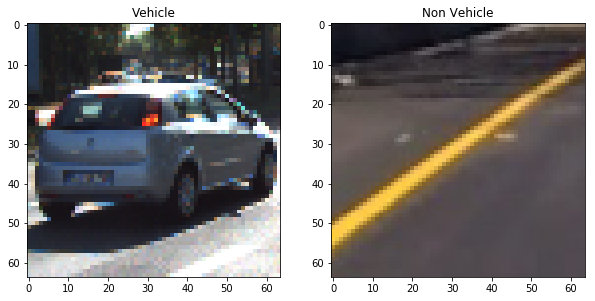

In [4]:
img_vehicle = cv2.imread('./examples/58.png')
img_non_vehicle = cv2.imread('./examples/extra27.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.set_title("Vehicle")
ax1.imshow(cv2.cvtColor(img_vehicle, cv2.COLOR_BGR2RGB))

ax2.set_title("Non Vehicle")
ax2.imshow(cv2.cvtColor(img_non_vehicle, cv2.COLOR_BGR2RGB))

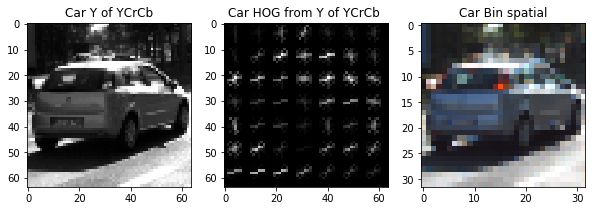

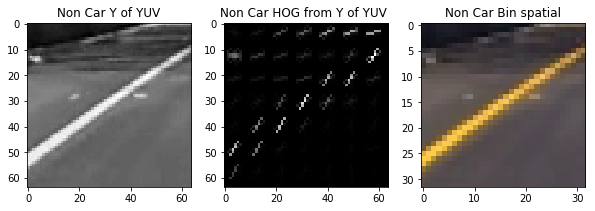

In [20]:
# HOG

pix_per_cell = 9
cell_per_block = 2
orient = 9

y_channel = convert_color(img_vehicle, 'YCrCb')[:,:, 0]
_, hog_yuv = get_hog_features(y_channel, 
                        orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

img_car_bs = bin_spatial(convert_color(img_vehicle), size=(32, 32))

y_channel_nc = convert_color(img_non_vehicle, 'YUV')[:,:, 0]
_, hog_yuv_nc = get_hog_features(y_channel_nc, 
                        orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

img_car_bs_nc = bin_spatial(convert_color(img_non_vehicle), size=(32, 32))


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

ax1.set_title("Car Y of YCrCb")
ax1.imshow(y_channel, cmap='gray')

ax2.set_title("Car HOG from Y of YCrCb ")
ax2.imshow(hog_yuv, cmap='gray')

ax3.set_title("Car Bin spatial")
ax3.imshow(cv2.cvtColor(img_car_bs, cv2.COLOR_BGR2RGB), cmap='gray')

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

ax1.set_title("Non Car Y of YUV")
ax1.imshow(y_channel_nc, cmap='gray')

ax2.set_title("Non Car HOG from Y of YUV ")
ax2.imshow(hog_yuv_nc, cmap='gray')

ax3.set_title("Non Car Bin spatial")
ax3.imshow(cv2.cvtColor(img_car_bs_nc, cv2.COLOR_BGR2RGB), cmap='gray')


# Track vehicle pipeline

Load dataset 

1) histogram of color uses YCrCb, to split the pixels of car from non cars
   
2) spatial binning of color downs the resolution mantaning the resources
   
3) compute HOG (Histogram of oriented gradients) allows for robust variation in the shape
   
4) combine and normalize features

5) build the SVM classifier

6) build windows

The images of test vehicles were separated manually by containing images in series (very similar). This could cause the test and training to have very similar images, causing overfitting.

In [5]:
# load the dataset

from sklearn.model_selection import train_test_split

def load_data(path, is_car=True):
    X = []
    y = None
    
    files = glob.glob(path)
    
    for file in files:
        img = cv2.imread(file)
        X.append(img)
        
    if is_car:
        y = np.ones(len(X))
    else:
        y = np.zeros(len(X))

    return np.array(X), y

X_train, y_train = load_data('./data/vehicles/train_data/**/*.png')
X_test, y_test = load_data('./data/vehicles/test_data/**/*.png')

rand_state = np.random.randint(0, 100)
X_data_noncar, y_data_noncar = load_data('./data/non-vehicles/**/*.png', False)

X_train_noncar, X_test_noncar, y_train_noncar, y_test_noncar = train_test_split(
    X_data_noncar, y_data_noncar, test_size=0.2, random_state=rand_state)

n_train_car = len(X_train)
n_test_car = len(X_test)
n_train_noncar = len(X_train_noncar)
n_test_noncar = len(X_test_noncar)

# metrics

image_shape = X_train[0].shape[:-1]

print("Number of training car examples =", n_train_car)
print("Number of testing car examples =", n_test_car)

print("Number of training non car examples =", n_train_noncar)
print("Number of testing non car examples =", n_test_noncar)

print("Image data shape =", image_shape)

Number of training car examples = 7033
Number of testing car examples = 1759
Number of training non car examples = 7174
Number of testing non car examples = 1794
Image data shape = (64, 64)


## Train the model

In [5]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

def extract_features(images, orient, pix_per_cell, cell_per_block, 
                     cspace='LUV', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256)):
    features = []
    for image in images:
        image_featues = []
        
        feature_image = convert_color(image, cspace)  
        spatial_features = bin_spatial(feature_image, size=spatial_size, feature_vector=True)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
            
        hog_features = np.ravel(hog_features)
        '''
        print('colorspace', cspace)
        print('feature_image shape', feature_image.shape)
        print('spatial_features shape', spatial_features.shape)
        print('hist_features shape', hist_features.shape)
        print('hog_features shape', np.array(hog_features).shape)
        '''
        image_featues.append(spatial_features)
        image_featues.append(hist_features)
        image_featues.append(hog_features)
        
        features.append(np.concatenate(image_featues))
        
    return features

In [7]:
spatial = (32, 32)
histbin = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
cspace='YCrCb'

X_train_features = extract_features(X_train, orient, pix_per_cell, cell_per_block, 
                                    spatial_size=spatial, hist_bins=histbin, cspace=cspace)
X_train_features_noncar = extract_features(X_train_noncar, orient, pix_per_cell, cell_per_block,  
                                           spatial_size=spatial, hist_bins=histbin, cspace=cspace)
X_test_features = extract_features(X_test, orient, pix_per_cell, cell_per_block,  
                                   spatial_size=spatial, hist_bins=histbin, cspace=cspace)
X_test_features_noncar = extract_features(X_test_noncar, orient, pix_per_cell, cell_per_block,  
                                          spatial_size=spatial, hist_bins=histbin, cspace=cspace)

/Users/matheus.souza/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [8]:
print(np.array(X_train_features).shape)

(7033, 8460)


In [9]:
from sklearn.utils import shuffle
import pickle

X = np.vstack((X_train_features, X_train_features_noncar)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((y_train, y_train_noncar))

scaled_X, y = shuffle(scaled_X, y)

X_t = np.vstack((X_test_features, X_test_features_noncar)).astype(np.float64)                        
X_scaler_test = StandardScaler().fit(X_t)
scaled_X_test = X_scaler_test.transform(X_t)

# Define the labels vector
y_t = np.hstack((y_test, y_test_noncar))

svc = LinearSVC()
t=time.time()
svc.fit(scaled_X, y)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(scaled_X_test, y_t), 4))

pickle.dump((svc, X_scaler), open('svc_classifier.p', 'wb'))

28.11 Seconds to train SVC...
Test Accuracy of SVC =  0.9865


In [10]:
t=time.time()
n_predict = 20
pred = svc.predict(scaled_X_test[0:n_predict])
print('My SVC predicts: ', pred)
print('For these',n_predict, 'labels: ', y_t[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

corrects = [1 for i, j in zip(pred, y_t[0:n_predict]) if i == j]
print((len(corrects) / n_predict), "accuracy in predictions")

My SVC predicts:  [ 1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  0.]
For these 20 labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]
0.01055 Seconds to predict 20 labels with SVC
0.85 accuracy in predictions


In [5]:
# checkpoint for the classifier
import pickle
import time

svc, X_scaler = pickle.load(open('svc_classifier.p', mode='rb'))

### Find the cars

(20, 2, 2)


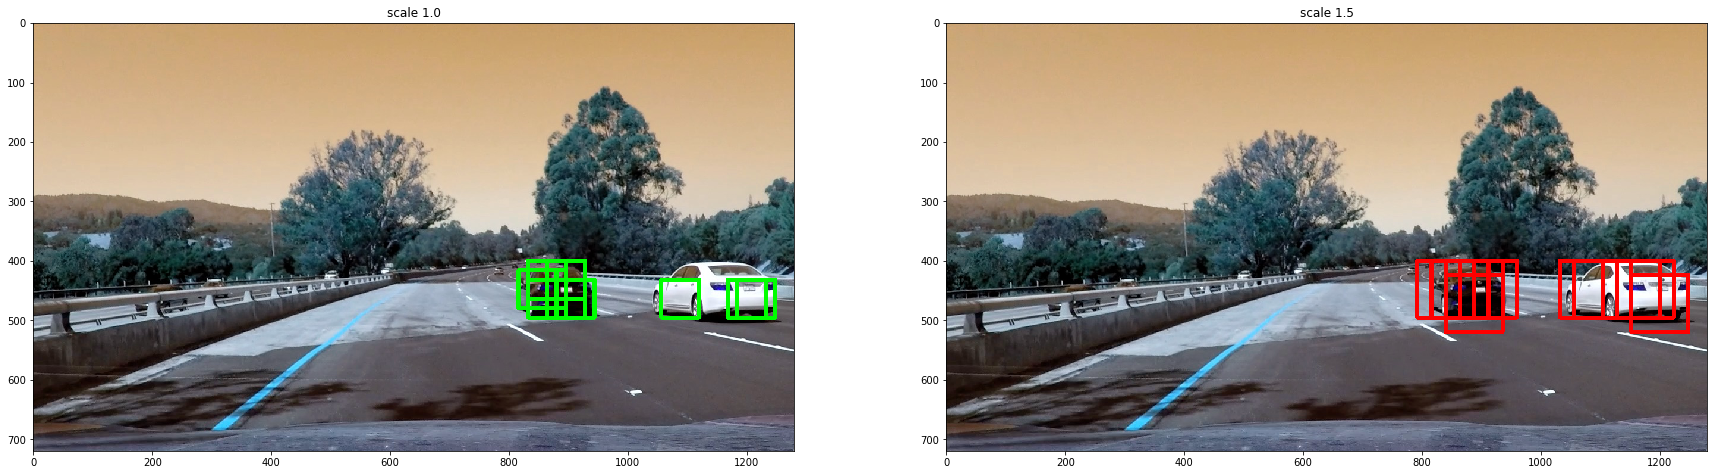

In [24]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, window_color, debug=None):
    
    draw_img = None
    if debug is not None:
        draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='YCrCb')

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    '''
    print('nxblocks', nxblocks)
    print('nyblocks', nyblocks)
    print('nfeat_per_block', nfeat_per_block)
    print('nblocks_per_window', nblocks_per_window)
    print('nxsteps', nxsteps)
    print('nysteps', nysteps)
    '''
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size, feature_vector=True)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            all_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            
            test_features = X_scaler.transform(all_features)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            
            if debug == 1: # show all windows
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),window_color,6) 
            elif debug == 2 and test_prediction == 1: #draws the predictions
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),window_color,6) 
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)

                points = [(xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)]
                bbox_list.append(points)

                

    return draw_img, bbox_list

image = cv2.imread('./test_images/test4.jpg')
draw_image = np.copy(image)

orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

# None 1, or 2 
# None: don't draw in image, just return the bbox
# 1: draw the search area and scale
# 2: draw box where the prediction is one
debug = 2

ystart = 400
ystop = 592

scale = 1.0
out1, bbox1 = find_cars(image, ystart, ystop, scale, svc, 
                    X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, (0,255,0), 
                        debug=debug)

ystart = 400
ystop = 656


scale = 1.5
out2, bbox2 = find_cars(image, ystart, ystop, scale, svc, 
                    X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, (255,0,0), 
                        debug=debug)

'''
ystart = 360
ystop = 600

scale = 2.0
out2, bbox2 = find_cars(image, ystart, ystop, scale, svc, 
                    X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, (0,255,0), 
                       debug=debug)
'''

bbox_list = []


for bbox in bbox1:
    bbox_list.append(bbox)

for bbox in bbox2:
    bbox_list.append(bbox)
    
print(np.array(bbox_list).shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

ax1.set_title("scale 1.0")
ax1.imshow(out1)

ax2.set_title("scale 1.5")
ax2.imshow(out2)

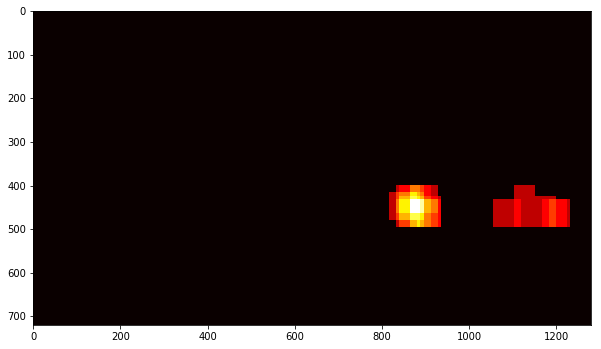

In [7]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
heat_map = add_heat(heat, bbox_list)

heat_map = apply_threshold(heat_map, 2)

f, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(heat_map, cmap='hot')

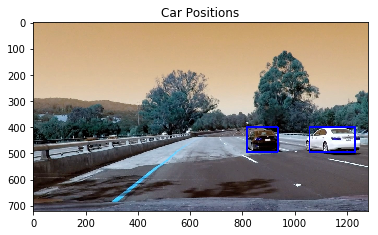

In [8]:
from scipy.ndimage.measurements import label

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heatmap = np.clip(heat_map, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.imshow(draw_img)
plt.title('Car Positions')

## Testing on video

In [9]:
from laneline_detection import *

In [94]:
# class to store the heatmaps of each frame thus allowing to accumulate 
# the heatmap of n frames to then apply the threshold
class FrameBuffer():
    def __init__(self):
        
        self.last_heats_maps = None # accumulated heatmaps frames
        self.n_frame_to_flush = 10 # number of frames to be stored before applying the threshold
        self.n_frame_buffer = 0 # counter that is incremented with each new frame buffered 
        
        self.cars_list = [] # list of detected cars
        
    def init_heatmap(self, img_shape_to_copy):
        self.last_heats_maps = np.zeros_like(img_shape_to_copy).astype(np.float)
    
    # checks if the buffer is full
    def time_to_flush(self):
        return self.n_frame_buffer > self.n_frame_to_flush # and len(h_nonzero[0])
    
    # this function is called in each frame to be stored
    # if the buffer is full, we return the heatmap with threshold
    # otherwise we will return None
    def add_heat(self, bbox_list, img_shape_to_copy):
        
        #heatmap to return
        heatmap = None
        
        if (self.last_heats_maps is None):
            self.init_heatmap(img_shape_to_copy)
        
        # if there are detected vehicle and the buffer is full
        # we apply the threshold, return the heatmap and reset the buffer
        if (len(bbox_list) > 0 and self.time_to_flush()):
            h_max = np.max(self.last_heats_maps)
            print('flushing max heat', h_max)
            
            self.apply_threshold(h_max)
            heatmap = self.last_heats_maps
            
            self.init_heatmap(img_shape_to_copy)
            
            self.n_frame_buffer = 0
            
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            self.last_heats_maps[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
        # we only count frames that have detected vehicles
        if len(bbox_list) > 0:
            self.n_frame_buffer += 1
        
        return heatmap
        
    def apply_threshold(self, max_heat_map):
        # the minimum limit value is 20 and the maximum is always 70% of the maximum value in the heat map
        #heatmap_threshold = max(20, 0.7 * max_heat_map)
        
        if max_heat_map < 50:
            heatmap_threshold = max_heat_map * .7
        elif max_heat_map < 100:
            heatmap_threshold = max_heat_map * .7
        else:
            heatmap_threshold = max_heat_map * .2
            
        heatmap_threshold = max(20, heatmap_threshold)
        
        print('threshold', heatmap_threshold)
        # Zero out pixels below the threshold
        self.last_heats_maps[self.last_heats_maps <= heatmap_threshold] = 0
        
        # if no intensity has passed the threshold, we set the heatmap to None
        nonzero = self.last_heats_maps.nonzero()
        if len(nonzero[0]) == 0:
            self.last_heats_maps = None

In [95]:
class VehicleTracking():
    def __init__(self):
        
        self.n_detections = 0 # number of times this vehicle was viewed

        self.n_nondetections = 0 # number of consecutive times this car was not detected
        
        self.recent_xfitted = [] # position of the x in the last n fits of the bouding box
        self.bestx = 0 # average of the x position in the last n fits

        self.recent_yfitted = [] # position of the y in the last n fits of the bouding box
        self.besty = 0 # average of the y position in the last n fits
        
        self.recent_wfitted = [] # position of the w in the last n fits of the bouding box
        self.bestw = 0 # average of the w position in the last n fits
        
        self.recent_hfitted = [] # position of the h in the last n fits of the bouding box
        self.besth = 0 # average of the h position in the last n fits
        
    def add_detection(self):
        self.n_detections += 1
        self.n_nondetections = 0
    
    def add_non_detection(self):
        self.n_nondetections += 1
        
        # if we reach the limit of no detections, we clean up the previous detections
        if (self.n_nondetections >= 25): # +- 1 sec
            print('reseting vehicle x->', self.bestx)
            self.n_detections = 0
            self.recent_xfitted = []
            self.bestx = 0
            self.recent_yfitted = []
            self.besty = 0
            self.recent_wfitted = []
            self.bestw = 0
            self.recent_hfitted = []
            self.besth = 0
    
    # checks whether a certain point intersects the box,
    # this is useful for determining whether the new detection is the same vehicle detected before
    def is_point_intersects(self, point):
        margin = 80
        
        x = point[0]
        y = point[1]
        
        # define a bigger search area considering the margin
        new_bestx_min = self.bestx - margin
        new_besty_min = self.besty - margin
        new_bestx_max = self.bestx + self.bestw + margin
        new_besty_max = self.besty + self.besth + margin
        
        # checks if point intersects
        return x > new_bestx_min and y > new_besty_min \
           and x < new_bestx_max and y < new_besty_max

    def add_fitted(self, xfitted, yfitted, wfitted, hfitted):
        n_avg = 4 # number to keep the average
        
        self.recent_xfitted.append(xfitted)
        self.recent_yfitted.append(yfitted)
        self.recent_wfitted.append(wfitted)
        self.recent_hfitted.append(hfitted)
        
        self.add_detection()
        
        self.recent_xfitted = self.recent_xfitted[-n_avg:]
        self.bestx = np.average(self.recent_xfitted, axis=0)
        
        self.recent_yfitted = self.recent_yfitted[-n_avg:]
        self.besty = np.average(self.recent_yfitted, axis=0)
        
        self.recent_wfitted = self.recent_wfitted[-n_avg:]
        self.bestw = np.average(self.recent_wfitted, axis=0)
        
        self.recent_hfitted = self.recent_hfitted[-n_avg:]
        self.besth = np.average(self.recent_hfitted, axis=0)

In [109]:

def process_image(image, left_line, right_line, frame_buffer, debug=None):
    
    ystart = 400
    ystop = 592

    scale = 1.0
    out1, bbox1 = find_cars(image, ystart, ystop, scale, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, (0,255,0), 
                            debug=debug)

    ystart = 400
    ystop = 656

    scale = 1.5
    out2, bbox2 = find_cars(image, ystart, ystop, scale, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, (255,0,0), 
                            debug=debug)
    
    # stores the boxes detected on the two scales
    bbox_list = []

    for bbox in bbox1:
        bbox_list.append(bbox)

    for bbox in bbox2:
        bbox_list.append(bbox)
    
    heat_map = frame_buffer.add_heat(bbox_list, image[:,:,0])
    draw_img = image
    
    # the number of min detection to considering a vehicle detected
    min_detection = 2
    
    if heat_map is not None: # heatmap was found?
    
        heat_map = np.clip(heat_map, 0, 255)
        
        labels = label(heat_map)
        
        # iterate over the new detections
        for car_number in range(1, labels[1]+1):
            nonzero = (labels[0] == car_number).nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            x = np.min(nonzerox)
            y = np.min(nonzeroy)
            max_x = np.max(nonzerox)
            max_y = np.max(nonzeroy)
            width = max_x - x
            height = max_y - y
            
            vehicle = None
            # if we have not yet detected any vehicles
            if len(frame_buffer.cars_list) == 0:
                vehicle = VehicleTracking()
                frame_buffer.cars_list.append(vehicle)
            else: 
                # if we already have detections, we iterate on each vehicle and we verify 
                # if the new detection is the same vehicle already detected previously
                for v in frame_buffer.cars_list:
                    
                    point_bottom_right = (max_x, max_y)
                    point_bottom_left = (x, max_y)
                    point_top_right = (max_x, y)
                    point_top_left = (x, y)
                    
                    # if any point is within the previous detection, we consider as the same vehicle
                    if v.is_point_intersects(point_bottom_right) or \
                        v.is_point_intersects(point_bottom_left) or \
                        v.is_point_intersects(point_top_right) or \
                        v.is_point_intersects(point_top_left):
                        print('is me!!')
                        vehicle = v
                        break
            
            # if we have find one more car
            if vehicle is None: 
                vehicle = VehicleTracking()
                frame_buffer.cars_list.append(vehicle)
            
            # after call
            vehicle.add_fitted(x, y, width, height)

            width_avg = vehicle.bestx + vehicle.bestw
            height_avg = vehicle.besty + vehicle.besth
            bbox = ((int(vehicle.bestx), int(vehicle.besty)), (int(width_avg), int(height_avg)))

            if vehicle.n_detections >= min_detection:
                cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
            
    else: # if the heatmap was not found, we tried to use previous detections
        for vehicle in frame_buffer.cars_list:
            
            # compute a non detection
            vehicle.add_non_detection()
            
            if vehicle.n_detections >= min_detection:
                width_avg = vehicle.bestx + vehicle.bestw
                height_avg = vehicle.besty + vehicle.besth
                bbox = ((int(vehicle.bestx), int(vehicle.besty)), (int(width_avg), int(height_avg)))
                
                cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
                
    # clean the list for bad detections
    frame_buffer.cars_list = [v for v in frame_buffer.cars_list if vehicle.n_nondetections < 25]  # +- 1 sec
    print('length cars_list', len(frame_buffer.cars_list))
    
    # calls the pipeline to detect lane lines (laneline_detection.py file)
    draw_img = detect_lines(draw_img, left_line, right_line)
    
    # count the cars detected
    num_cars_detected = np.sum([1 for v in frame_buffer.cars_list if vehicle.n_detections >= min_detection])
    
    text_number_cars = "{0:.0f} vehicle(s) detected".format(num_cars_detected)
    cv2.putText(draw_img, text_number_cars, (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 0), 2)
    
    return draw_img

In [110]:
from moviepy.editor import VideoFileClip

output_dir = 'video_output.mp4'

video_input = "project_video.mp4"

debug = None
clip1 = VideoFileClip(video_input)

left_line = Line()
right_line = Line()
frame_buffer = FrameBuffer()
white_clip = clip1.fl_image(lambda imagevideo: 
                            process_image(imagevideo, left_line, right_line, frame_buffer, debug=debug)) 

%time white_clip.write_videofile(output_dir, audio=False)

length cars_list 0
[MoviePy] >>>> Building video video_output.mp4
[MoviePy] Writing video video_output.mp4


  0%|          | 1/1261 [00:01<23:51,  1.14s/it]

length cars_list 0


  0%|          | 2/1261 [00:02<23:57,  1.14s/it]

length cars_list 0
length cars_list 0


  0%|          | 4/1261 [00:05<26:52,  1.28s/it]

length cars_list 0


  0%|          | 5/1261 [00:06<25:53,  1.24s/it]

length cars_list 0


  0%|          | 6/1261 [00:07<24:58,  1.19s/it]

length cars_list 0


  1%|          | 7/1261 [00:08<24:35,  1.18s/it]

length cars_list 0


  1%|          | 8/1261 [00:09<24:09,  1.16s/it]

length cars_list 0


  1%|          | 9/1261 [00:10<23:40,  1.13s/it]

length cars_list 0


  1%|          | 10/1261 [00:11<23:28,  1.13s/it]

length cars_list 0


  1%|          | 11/1261 [00:12<23:28,  1.13s/it]

flushing max heat 18.0
threshold 20
length cars_list 0


  1%|          | 12/1261 [00:14<23:12,  1.11s/it]

length cars_list 0


  1%|          | 13/1261 [00:15<23:16,  1.12s/it]

length cars_list 0


  1%|          | 14/1261 [00:16<23:09,  1.11s/it]

length cars_list 0


  1%|          | 15/1261 [00:17<23:06,  1.11s/it]

length cars_list 0


  1%|▏         | 16/1261 [00:18<22:58,  1.11s/it]

length cars_list 0


  1%|▏         | 17/1261 [00:19<23:05,  1.11s/it]

length cars_list 0


  1%|▏         | 18/1261 [00:20<23:02,  1.11s/it]

length cars_list 0
irregular distance horizontally 2.90714285714


  2%|▏         | 19/1261 [00:21<22:57,  1.11s/it]

length cars_list 0
irregular distance horizontally 2.94414285714


  2%|▏         | 20/1261 [00:22<22:59,  1.11s/it]

length cars_list 0


  2%|▏         | 21/1261 [00:24<22:57,  1.11s/it]

length cars_list 0


  2%|▏         | 22/1261 [00:25<23:18,  1.13s/it]

flushing max heat 21.0
threshold 20
length cars_list 1


  2%|▏         | 23/1261 [00:26<23:10,  1.12s/it]

length cars_list 1


  2%|▏         | 24/1261 [00:27<23:03,  1.12s/it]

length cars_list 1


  2%|▏         | 25/1261 [00:28<23:02,  1.12s/it]

length cars_list 1


  2%|▏         | 26/1261 [00:29<22:55,  1.11s/it]

length cars_list 1


  2%|▏         | 27/1261 [00:30<22:57,  1.12s/it]

length cars_list 1


  2%|▏         | 28/1261 [00:31<23:06,  1.12s/it]

length cars_list 1


  2%|▏         | 29/1261 [00:33<23:01,  1.12s/it]

length cars_list 1


  2%|▏         | 30/1261 [00:34<23:20,  1.14s/it]

length cars_list 1


  2%|▏         | 31/1261 [00:35<23:17,  1.14s/it]

length cars_list 1


  3%|▎         | 32/1261 [00:36<23:15,  1.14s/it]

length cars_list 1


  3%|▎         | 33/1261 [00:37<23:42,  1.16s/it]

length cars_list 1


  3%|▎         | 34/1261 [00:38<23:41,  1.16s/it]

flushing max heat 15.0
threshold 20
length cars_list 1


  3%|▎         | 35/1261 [00:40<23:45,  1.16s/it]

length cars_list 1


  3%|▎         | 36/1261 [00:41<23:22,  1.14s/it]

length cars_list 1


  3%|▎         | 37/1261 [00:42<22:59,  1.13s/it]

length cars_list 1


  3%|▎         | 38/1261 [00:43<22:44,  1.12s/it]

length cars_list 1


  3%|▎         | 39/1261 [00:44<22:31,  1.11s/it]

length cars_list 1


  3%|▎         | 40/1261 [00:45<22:26,  1.10s/it]

length cars_list 1


  3%|▎         | 41/1261 [00:46<22:30,  1.11s/it]

length cars_list 1


  3%|▎         | 42/1261 [00:47<22:33,  1.11s/it]

length cars_list 1


  3%|▎         | 43/1261 [00:48<22:49,  1.12s/it]

length cars_list 1
irregular distance horizontally 2.97057142857


  3%|▎         | 44/1261 [00:49<22:50,  1.13s/it]

length cars_list 1


  4%|▎         | 45/1261 [00:51<22:46,  1.12s/it]

length cars_list 1


  4%|▎         | 46/1261 [00:52<22:50,  1.13s/it]

flushing max heat 13.0
threshold 20
length cars_list 1


  4%|▎         | 47/1261 [00:53<22:58,  1.14s/it]

reseting vehicle x-> 96.0
length cars_list 0


  4%|▍         | 48/1261 [00:54<22:52,  1.13s/it]

length cars_list 0


  4%|▍         | 49/1261 [00:55<22:57,  1.14s/it]

length cars_list 0


  4%|▍         | 50/1261 [00:56<23:17,  1.15s/it]

length cars_list 0


  4%|▍         | 51/1261 [00:57<23:06,  1.15s/it]

length cars_list 0


  4%|▍         | 52/1261 [00:59<23:08,  1.15s/it]

length cars_list 0


  4%|▍         | 53/1261 [01:00<23:06,  1.15s/it]

length cars_list 0


  4%|▍         | 54/1261 [01:01<23:10,  1.15s/it]

length cars_list 0


  4%|▍         | 55/1261 [01:02<23:13,  1.16s/it]

length cars_list 0


  4%|▍         | 56/1261 [01:03<23:32,  1.17s/it]

length cars_list 0


  5%|▍         | 57/1261 [01:04<23:13,  1.16s/it]

length cars_list 0


  5%|▍         | 58/1261 [01:06<23:03,  1.15s/it]

length cars_list 0


  5%|▍         | 59/1261 [01:07<22:49,  1.14s/it]

length cars_list 0


  5%|▍         | 60/1261 [01:08<22:53,  1.14s/it]

length cars_list 0


  5%|▍         | 61/1261 [01:09<22:41,  1.13s/it]

length cars_list 0


  5%|▍         | 62/1261 [01:10<22:36,  1.13s/it]

length cars_list 0


  5%|▍         | 63/1261 [01:11<22:43,  1.14s/it]

length cars_list 0


  5%|▌         | 64/1261 [01:12<23:06,  1.16s/it]

length cars_list 0


  5%|▌         | 65/1261 [01:14<22:56,  1.15s/it]

length cars_list 0


  5%|▌         | 66/1261 [01:15<22:51,  1.15s/it]

flushing max heat 8.0
threshold 20
length cars_list 0


  5%|▌         | 67/1261 [01:16<22:46,  1.14s/it]

length cars_list 0


  5%|▌         | 68/1261 [01:17<22:47,  1.15s/it]

length cars_list 0
irregular distance horizontally 2.90714285714
init search from stratch


  5%|▌         | 69/1261 [01:18<22:39,  1.14s/it]

length cars_list 0
irregular distance horizontally 2.92828571429


  6%|▌         | 70/1261 [01:19<22:24,  1.13s/it]

length cars_list 0
irregular distance horizontally 2.98114285714


  6%|▌         | 71/1261 [01:20<22:24,  1.13s/it]

length cars_list 0


  6%|▌         | 72/1261 [01:22<22:30,  1.14s/it]

length cars_list 0


  6%|▌         | 73/1261 [01:23<22:22,  1.13s/it]

length cars_list 0


  6%|▌         | 74/1261 [01:24<22:27,  1.13s/it]

length cars_list 0


  6%|▌         | 75/1261 [01:25<22:17,  1.13s/it]

length cars_list 0


  6%|▌         | 76/1261 [01:26<22:27,  1.14s/it]

length cars_list 0


  6%|▌         | 77/1261 [01:27<22:16,  1.13s/it]

length cars_list 0


  6%|▌         | 78/1261 [01:28<22:16,  1.13s/it]

length cars_list 0


  6%|▋         | 79/1261 [01:29<22:10,  1.13s/it]

length cars_list 0


  6%|▋         | 80/1261 [01:31<22:13,  1.13s/it]

length cars_list 0


  6%|▋         | 81/1261 [01:32<21:58,  1.12s/it]

length cars_list 0


  7%|▋         | 82/1261 [01:33<22:10,  1.13s/it]

length cars_list 0


  7%|▋         | 83/1261 [01:34<22:07,  1.13s/it]

length cars_list 0


  7%|▋         | 84/1261 [01:35<22:04,  1.13s/it]

length cars_list 0


  7%|▋         | 85/1261 [01:36<21:50,  1.11s/it]

length cars_list 0


  7%|▋         | 86/1261 [01:37<22:04,  1.13s/it]

length cars_list 0


  7%|▋         | 87/1261 [01:38<22:07,  1.13s/it]

length cars_list 0


  7%|▋         | 88/1261 [01:40<22:09,  1.13s/it]

length cars_list 0


  7%|▋         | 89/1261 [01:41<22:06,  1.13s/it]

length cars_list 0


  7%|▋         | 90/1261 [01:42<21:58,  1.13s/it]

length cars_list 0


  7%|▋         | 91/1261 [01:43<21:49,  1.12s/it]

length cars_list 0


  7%|▋         | 92/1261 [01:44<21:42,  1.11s/it]

length cars_list 0


  7%|▋         | 93/1261 [01:45<21:37,  1.11s/it]

flushing max heat 4.0
threshold 20
length cars_list 0
irregular distance horizontally 2.96


  7%|▋         | 94/1261 [01:46<21:34,  1.11s/it]

length cars_list 0


  8%|▊         | 95/1261 [01:47<21:33,  1.11s/it]

length cars_list 0


  8%|▊         | 96/1261 [01:48<21:42,  1.12s/it]

length cars_list 0
init search from stratch


  8%|▊         | 97/1261 [01:50<22:06,  1.14s/it]

length cars_list 0


  8%|▊         | 98/1261 [01:51<21:55,  1.13s/it]

length cars_list 0


  8%|▊         | 99/1261 [01:52<21:42,  1.12s/it]

length cars_list 0


  8%|▊         | 100/1261 [01:53<21:43,  1.12s/it]

length cars_list 0


  8%|▊         | 101/1261 [01:54<21:30,  1.11s/it]

length cars_list 0


  8%|▊         | 102/1261 [01:55<21:38,  1.12s/it]

length cars_list 0


  8%|▊         | 103/1261 [01:56<21:38,  1.12s/it]

length cars_list 0


  8%|▊         | 104/1261 [01:58<21:50,  1.13s/it]

length cars_list 0


  8%|▊         | 105/1261 [01:59<21:58,  1.14s/it]

length cars_list 0


  8%|▊         | 106/1261 [02:00<21:49,  1.13s/it]

flushing max heat 8.0
threshold 20
length cars_list 0


  8%|▊         | 107/1261 [02:01<21:56,  1.14s/it]

length cars_list 0


  9%|▊         | 108/1261 [02:02<21:56,  1.14s/it]

length cars_list 0


  9%|▊         | 109/1261 [02:03<22:09,  1.15s/it]

length cars_list 0


  9%|▊         | 110/1261 [02:04<22:02,  1.15s/it]

length cars_list 0


  9%|▉         | 111/1261 [02:06<21:58,  1.15s/it]

length cars_list 0


  9%|▉         | 112/1261 [02:07<21:51,  1.14s/it]

length cars_list 0


  9%|▉         | 113/1261 [02:08<21:46,  1.14s/it]

length cars_list 0


  9%|▉         | 114/1261 [02:09<21:42,  1.14s/it]

length cars_list 0


  9%|▉         | 115/1261 [02:10<21:37,  1.13s/it]

length cars_list 0


  9%|▉         | 116/1261 [02:11<21:40,  1.14s/it]

length cars_list 0


  9%|▉         | 117/1261 [02:12<21:47,  1.14s/it]

length cars_list 0


  9%|▉         | 118/1261 [02:13<21:38,  1.14s/it]

length cars_list 0


  9%|▉         | 119/1261 [02:15<21:48,  1.15s/it]

flushing max heat 7.0
threshold 20
length cars_list 0


 10%|▉         | 120/1261 [02:16<21:47,  1.15s/it]

length cars_list 0


 10%|▉         | 121/1261 [02:17<21:43,  1.14s/it]

length cars_list 0


 10%|▉         | 122/1261 [02:18<21:46,  1.15s/it]

length cars_list 0


 10%|▉         | 123/1261 [02:19<21:40,  1.14s/it]

length cars_list 0


 10%|▉         | 124/1261 [02:20<21:34,  1.14s/it]

length cars_list 0


 10%|▉         | 125/1261 [02:21<21:36,  1.14s/it]

length cars_list 0


 10%|▉         | 126/1261 [02:23<21:28,  1.14s/it]

length cars_list 0


 10%|█         | 127/1261 [02:24<21:18,  1.13s/it]

length cars_list 0


 10%|█         | 128/1261 [02:25<21:21,  1.13s/it]

length cars_list 0


 10%|█         | 129/1261 [02:26<21:08,  1.12s/it]

length cars_list 0


 10%|█         | 130/1261 [02:27<21:03,  1.12s/it]

length cars_list 0


 10%|█         | 131/1261 [02:28<21:21,  1.13s/it]

flushing max heat 12.0
threshold 20
length cars_list 0


 10%|█         | 132/1261 [02:29<21:24,  1.14s/it]

length cars_list 0


 11%|█         | 133/1261 [02:31<21:26,  1.14s/it]

length cars_list 0


 11%|█         | 134/1261 [02:32<21:28,  1.14s/it]

length cars_list 0


 11%|█         | 135/1261 [02:33<21:28,  1.14s/it]

length cars_list 0


 11%|█         | 136/1261 [02:34<21:37,  1.15s/it]

length cars_list 0


 11%|█         | 137/1261 [02:35<21:22,  1.14s/it]

length cars_list 0


 11%|█         | 138/1261 [02:36<21:04,  1.13s/it]

length cars_list 0


 11%|█         | 139/1261 [02:37<21:35,  1.15s/it]

length cars_list 0


 11%|█         | 140/1261 [02:39<21:26,  1.15s/it]

length cars_list 0


 11%|█         | 141/1261 [02:40<21:32,  1.15s/it]

length cars_list 0


 11%|█▏        | 142/1261 [02:41<21:24,  1.15s/it]

flushing max heat 9.0
threshold 20
length cars_list 0


 11%|█▏        | 143/1261 [02:42<21:31,  1.16s/it]

length cars_list 0


 11%|█▏        | 144/1261 [02:43<21:51,  1.17s/it]

length cars_list 0


 11%|█▏        | 145/1261 [02:44<21:47,  1.17s/it]

length cars_list 0


 12%|█▏        | 146/1261 [02:46<21:35,  1.16s/it]

length cars_list 0


 12%|█▏        | 147/1261 [02:47<21:28,  1.16s/it]

length cars_list 0


 12%|█▏        | 148/1261 [02:48<21:29,  1.16s/it]

length cars_list 0


 12%|█▏        | 149/1261 [02:49<21:18,  1.15s/it]

length cars_list 0


 12%|█▏        | 150/1261 [02:50<21:06,  1.14s/it]

length cars_list 0


 12%|█▏        | 151/1261 [02:51<21:00,  1.14s/it]

length cars_list 0


 12%|█▏        | 152/1261 [02:52<21:04,  1.14s/it]

length cars_list 0


 12%|█▏        | 153/1261 [02:54<21:20,  1.16s/it]

flushing max heat 24.0
threshold 20
length cars_list 1


 12%|█▏        | 154/1261 [02:55<21:16,  1.15s/it]

length cars_list 1


 12%|█▏        | 155/1261 [02:56<21:06,  1.15s/it]

length cars_list 1


 12%|█▏        | 156/1261 [02:57<20:46,  1.13s/it]

length cars_list 1


 12%|█▏        | 157/1261 [02:58<20:38,  1.12s/it]

length cars_list 1


 13%|█▎        | 158/1261 [02:59<20:41,  1.13s/it]

length cars_list 1


 13%|█▎        | 159/1261 [03:00<20:47,  1.13s/it]

length cars_list 1


 13%|█▎        | 160/1261 [03:01<20:40,  1.13s/it]

length cars_list 1


 13%|█▎        | 161/1261 [03:03<20:39,  1.13s/it]

length cars_list 1


 13%|█▎        | 162/1261 [03:04<20:36,  1.13s/it]

length cars_list 1


 13%|█▎        | 163/1261 [03:05<20:33,  1.12s/it]

length cars_list 1


 13%|█▎        | 164/1261 [03:06<20:37,  1.13s/it]

length cars_list 1


 13%|█▎        | 165/1261 [03:07<20:33,  1.13s/it]

length cars_list 1


 13%|█▎        | 166/1261 [03:08<20:39,  1.13s/it]

length cars_list 1


 13%|█▎        | 167/1261 [03:09<20:39,  1.13s/it]

flushing max heat 17.0
threshold 20
length cars_list 1


 13%|█▎        | 168/1261 [03:10<20:33,  1.13s/it]

length cars_list 1


 13%|█▎        | 169/1261 [03:12<20:36,  1.13s/it]

length cars_list 1


 13%|█▎        | 170/1261 [03:13<20:30,  1.13s/it]

length cars_list 1


 14%|█▎        | 171/1261 [03:14<20:29,  1.13s/it]

length cars_list 1


 14%|█▎        | 172/1261 [03:15<20:17,  1.12s/it]

length cars_list 1


 14%|█▎        | 173/1261 [03:16<20:10,  1.11s/it]

length cars_list 1


 14%|█▍        | 174/1261 [03:17<20:04,  1.11s/it]

length cars_list 1


 14%|█▍        | 175/1261 [03:18<20:14,  1.12s/it]

length cars_list 1


 14%|█▍        | 176/1261 [03:19<20:24,  1.13s/it]

length cars_list 1


 14%|█▍        | 177/1261 [03:21<20:23,  1.13s/it]

length cars_list 1


 14%|█▍        | 178/1261 [03:22<20:31,  1.14s/it]

flushing max heat 23.0
threshold 20
is me!!
length cars_list 1


 14%|█▍        | 179/1261 [03:23<20:29,  1.14s/it]

length cars_list 1


 14%|█▍        | 180/1261 [03:24<20:30,  1.14s/it]

length cars_list 1


 14%|█▍        | 181/1261 [03:25<20:33,  1.14s/it]

length cars_list 1


 14%|█▍        | 182/1261 [03:26<20:31,  1.14s/it]

length cars_list 1


 15%|█▍        | 183/1261 [03:27<20:28,  1.14s/it]

length cars_list 1


 15%|█▍        | 184/1261 [03:29<20:14,  1.13s/it]

length cars_list 1


 15%|█▍        | 185/1261 [03:30<20:13,  1.13s/it]

length cars_list 1


 15%|█▍        | 186/1261 [03:31<20:05,  1.12s/it]

length cars_list 1


 15%|█▍        | 187/1261 [03:32<19:57,  1.12s/it]

length cars_list 1


 15%|█▍        | 188/1261 [03:33<20:00,  1.12s/it]

length cars_list 1


 15%|█▍        | 189/1261 [03:34<20:05,  1.12s/it]

flushing max heat 28.0
threshold 20
is me!!
is me!!
length cars_list 1


 15%|█▌        | 190/1261 [03:35<19:57,  1.12s/it]

length cars_list 1


 15%|█▌        | 191/1261 [03:36<19:50,  1.11s/it]

length cars_list 1


 15%|█▌        | 192/1261 [03:37<19:48,  1.11s/it]

length cars_list 1


 15%|█▌        | 193/1261 [03:39<19:50,  1.11s/it]

length cars_list 1
irregular distance horizontally 2.93885714286


 15%|█▌        | 194/1261 [03:40<19:59,  1.12s/it]

length cars_list 1
irregular distance horizontally 2.97057142857


 15%|█▌        | 195/1261 [03:41<19:56,  1.12s/it]

length cars_list 1
irregular distance horizontally 2.997


 16%|█▌        | 196/1261 [03:42<20:05,  1.13s/it]

length cars_list 1


 16%|█▌        | 197/1261 [03:43<20:11,  1.14s/it]

length cars_list 1


 16%|█▌        | 198/1261 [03:44<20:11,  1.14s/it]

length cars_list 1


 16%|█▌        | 199/1261 [03:45<20:08,  1.14s/it]

length cars_list 1


 16%|█▌        | 200/1261 [03:47<20:21,  1.15s/it]

flushing max heat 22.0
threshold 20
is me!!
is me!!
length cars_list 1


 16%|█▌        | 201/1261 [03:48<20:17,  1.15s/it]

length cars_list 1


 16%|█▌        | 202/1261 [03:49<20:14,  1.15s/it]

length cars_list 1


 16%|█▌        | 203/1261 [03:50<20:12,  1.15s/it]

length cars_list 1


 16%|█▌        | 204/1261 [03:51<20:02,  1.14s/it]

length cars_list 1


 16%|█▋        | 205/1261 [03:52<20:00,  1.14s/it]

length cars_list 1


 16%|█▋        | 206/1261 [03:53<20:00,  1.14s/it]

length cars_list 1


 16%|█▋        | 207/1261 [03:55<19:47,  1.13s/it]

length cars_list 1


 16%|█▋        | 208/1261 [03:56<19:44,  1.13s/it]

length cars_list 1


 17%|█▋        | 209/1261 [03:57<19:44,  1.13s/it]

length cars_list 1


 17%|█▋        | 210/1261 [03:58<19:48,  1.13s/it]

length cars_list 1


 17%|█▋        | 211/1261 [03:59<20:05,  1.15s/it]

flushing max heat 39.0
threshold 27.3
is me!!
is me!!
length cars_list 1


 17%|█▋        | 212/1261 [04:00<19:56,  1.14s/it]

length cars_list 1


 17%|█▋        | 213/1261 [04:01<19:51,  1.14s/it]

length cars_list 1


 17%|█▋        | 214/1261 [04:02<19:37,  1.12s/it]

length cars_list 1


 17%|█▋        | 215/1261 [04:04<20:10,  1.16s/it]

length cars_list 1


 17%|█▋        | 216/1261 [04:05<20:02,  1.15s/it]

length cars_list 1


 17%|█▋        | 217/1261 [04:06<20:04,  1.15s/it]

length cars_list 1


 17%|█▋        | 218/1261 [04:07<20:05,  1.16s/it]

length cars_list 1


 17%|█▋        | 219/1261 [04:08<20:06,  1.16s/it]

length cars_list 1


 17%|█▋        | 220/1261 [04:09<19:57,  1.15s/it]

length cars_list 1


 18%|█▊        | 221/1261 [04:11<19:57,  1.15s/it]

length cars_list 1


 18%|█▊        | 222/1261 [04:12<20:04,  1.16s/it]

flushing max heat 35.0
threshold 24.5
is me!!
length cars_list 1


 18%|█▊        | 223/1261 [04:13<19:52,  1.15s/it]

length cars_list 1


 18%|█▊        | 224/1261 [04:14<19:34,  1.13s/it]

length cars_list 1


 18%|█▊        | 225/1261 [04:15<19:29,  1.13s/it]

length cars_list 1


 18%|█▊        | 226/1261 [04:16<19:20,  1.12s/it]

length cars_list 1


 18%|█▊        | 227/1261 [04:17<19:14,  1.12s/it]

length cars_list 1


 18%|█▊        | 228/1261 [04:18<19:08,  1.11s/it]

length cars_list 1


 18%|█▊        | 229/1261 [04:20<19:07,  1.11s/it]

length cars_list 1


 18%|█▊        | 230/1261 [04:21<19:03,  1.11s/it]

length cars_list 1


 18%|█▊        | 231/1261 [04:22<19:05,  1.11s/it]

length cars_list 1


 18%|█▊        | 232/1261 [04:23<19:11,  1.12s/it]

length cars_list 1


 18%|█▊        | 233/1261 [04:24<19:29,  1.14s/it]

flushing max heat 47.0
threshold 32.9
is me!!
length cars_list 1


 19%|█▊        | 234/1261 [04:25<19:27,  1.14s/it]

length cars_list 1


 19%|█▊        | 235/1261 [04:26<19:13,  1.12s/it]

length cars_list 1


 19%|█▊        | 236/1261 [04:27<18:59,  1.11s/it]

length cars_list 1


 19%|█▉        | 237/1261 [04:28<18:58,  1.11s/it]

length cars_list 1


 19%|█▉        | 238/1261 [04:30<18:55,  1.11s/it]

length cars_list 1


 19%|█▉        | 239/1261 [04:31<18:59,  1.12s/it]

length cars_list 1


 19%|█▉        | 240/1261 [04:32<18:51,  1.11s/it]

length cars_list 1


 19%|█▉        | 241/1261 [04:33<18:59,  1.12s/it]

length cars_list 1


 19%|█▉        | 242/1261 [04:34<18:50,  1.11s/it]

length cars_list 1


 19%|█▉        | 243/1261 [04:35<18:59,  1.12s/it]

length cars_list 1


 19%|█▉        | 244/1261 [04:36<19:11,  1.13s/it]

flushing max heat 41.0
threshold 28.7
is me!!
length cars_list 1


 19%|█▉        | 245/1261 [04:38<19:50,  1.17s/it]

length cars_list 1


 20%|█▉        | 246/1261 [04:39<19:37,  1.16s/it]

length cars_list 1


 20%|█▉        | 247/1261 [04:40<19:43,  1.17s/it]

length cars_list 1


 20%|█▉        | 248/1261 [04:41<19:34,  1.16s/it]

length cars_list 1


 20%|█▉        | 249/1261 [04:42<19:31,  1.16s/it]

length cars_list 1


 20%|█▉        | 250/1261 [04:43<19:26,  1.15s/it]

length cars_list 1


 20%|█▉        | 251/1261 [04:45<19:18,  1.15s/it]

length cars_list 1


 20%|█▉        | 252/1261 [04:46<19:10,  1.14s/it]

length cars_list 1


 20%|██        | 253/1261 [04:47<18:56,  1.13s/it]

length cars_list 1


 20%|██        | 254/1261 [04:48<18:47,  1.12s/it]

length cars_list 1


 20%|██        | 255/1261 [04:49<18:53,  1.13s/it]

flushing max heat 54.0
threshold 37.8
is me!!
length cars_list 1


 20%|██        | 256/1261 [04:50<18:48,  1.12s/it]

length cars_list 1


 20%|██        | 257/1261 [04:51<18:39,  1.12s/it]

length cars_list 1


 20%|██        | 258/1261 [04:52<18:34,  1.11s/it]

length cars_list 1


 21%|██        | 259/1261 [04:53<18:40,  1.12s/it]

length cars_list 1


 21%|██        | 260/1261 [04:55<18:42,  1.12s/it]

length cars_list 1


 21%|██        | 261/1261 [04:56<18:43,  1.12s/it]

length cars_list 1


 21%|██        | 262/1261 [04:57<18:34,  1.12s/it]

length cars_list 1


 21%|██        | 263/1261 [04:58<18:43,  1.13s/it]

length cars_list 1


 21%|██        | 264/1261 [04:59<18:42,  1.13s/it]

length cars_list 1


 21%|██        | 265/1261 [05:00<18:46,  1.13s/it]

length cars_list 1


 21%|██        | 266/1261 [05:01<18:53,  1.14s/it]

flushing max heat 60.0
threshold 42.0
is me!!
is me!!
length cars_list 1


 21%|██        | 267/1261 [05:03<19:10,  1.16s/it]

length cars_list 1


 21%|██▏       | 268/1261 [05:04<19:25,  1.17s/it]

length cars_list 1


 21%|██▏       | 269/1261 [05:05<19:21,  1.17s/it]

length cars_list 1


 21%|██▏       | 270/1261 [05:06<19:09,  1.16s/it]

length cars_list 1


 21%|██▏       | 271/1261 [05:07<19:06,  1.16s/it]

length cars_list 1


 22%|██▏       | 272/1261 [05:08<19:03,  1.16s/it]

length cars_list 1


 22%|██▏       | 273/1261 [05:10<19:03,  1.16s/it]

length cars_list 1


 22%|██▏       | 274/1261 [05:11<19:02,  1.16s/it]

length cars_list 1


 22%|██▏       | 275/1261 [05:12<19:00,  1.16s/it]

length cars_list 1


 22%|██▏       | 276/1261 [05:13<18:51,  1.15s/it]

length cars_list 1


 22%|██▏       | 277/1261 [05:14<18:53,  1.15s/it]

flushing max heat 61.0
threshold 42.7
is me!!
is me!!
length cars_list 1


 22%|██▏       | 278/1261 [05:15<19:00,  1.16s/it]

length cars_list 1


 22%|██▏       | 279/1261 [05:16<18:53,  1.15s/it]

length cars_list 1


 22%|██▏       | 280/1261 [05:18<18:45,  1.15s/it]

length cars_list 1


 22%|██▏       | 281/1261 [05:19<18:45,  1.15s/it]

length cars_list 1


 22%|██▏       | 282/1261 [05:20<18:37,  1.14s/it]

length cars_list 1


 22%|██▏       | 283/1261 [05:21<18:38,  1.14s/it]

length cars_list 1


 23%|██▎       | 284/1261 [05:22<18:32,  1.14s/it]

length cars_list 1


 23%|██▎       | 285/1261 [05:23<18:41,  1.15s/it]

length cars_list 1


 23%|██▎       | 286/1261 [05:24<18:31,  1.14s/it]

length cars_list 1


 23%|██▎       | 287/1261 [05:26<18:23,  1.13s/it]

length cars_list 1


 23%|██▎       | 288/1261 [05:27<18:24,  1.14s/it]

flushing max heat 76.0
threshold 53.2
is me!!
is me!!
length cars_list 1


 23%|██▎       | 289/1261 [05:28<18:14,  1.13s/it]

length cars_list 1


 23%|██▎       | 290/1261 [05:29<18:02,  1.11s/it]

length cars_list 1


 23%|██▎       | 291/1261 [05:30<17:53,  1.11s/it]

length cars_list 1


 23%|██▎       | 292/1261 [05:31<17:53,  1.11s/it]

length cars_list 1


 23%|██▎       | 293/1261 [05:32<17:59,  1.12s/it]

length cars_list 1


 23%|██▎       | 294/1261 [05:33<18:22,  1.14s/it]

length cars_list 1


 23%|██▎       | 295/1261 [05:35<18:20,  1.14s/it]

length cars_list 1


 23%|██▎       | 296/1261 [05:36<18:09,  1.13s/it]

length cars_list 1


 24%|██▎       | 297/1261 [05:37<18:04,  1.12s/it]

length cars_list 1


 24%|██▎       | 298/1261 [05:38<18:08,  1.13s/it]

length cars_list 1


 24%|██▎       | 299/1261 [05:39<18:18,  1.14s/it]

flushing max heat 84.0
threshold 58.8
is me!!
is me!!
length cars_list 1


 24%|██▍       | 300/1261 [05:40<18:21,  1.15s/it]

length cars_list 1


 24%|██▍       | 301/1261 [05:41<18:20,  1.15s/it]

length cars_list 1


 24%|██▍       | 302/1261 [05:43<18:20,  1.15s/it]

length cars_list 1


 24%|██▍       | 303/1261 [05:44<18:09,  1.14s/it]

length cars_list 1


 24%|██▍       | 304/1261 [05:45<17:53,  1.12s/it]

length cars_list 1


 24%|██▍       | 305/1261 [05:46<18:00,  1.13s/it]

length cars_list 1
init search from stratch


 24%|██▍       | 306/1261 [05:47<18:09,  1.14s/it]

length cars_list 1


 24%|██▍       | 307/1261 [05:48<17:57,  1.13s/it]

length cars_list 1


 24%|██▍       | 308/1261 [05:49<17:52,  1.13s/it]

length cars_list 1


 25%|██▍       | 309/1261 [05:50<17:55,  1.13s/it]

length cars_list 1


 25%|██▍       | 310/1261 [05:52<18:03,  1.14s/it]

flushing max heat 64.0
threshold 44.8
is me!!
length cars_list 1


 25%|██▍       | 311/1261 [05:53<17:59,  1.14s/it]

length cars_list 1


 25%|██▍       | 312/1261 [05:54<17:54,  1.13s/it]

length cars_list 1


 25%|██▍       | 313/1261 [05:55<17:54,  1.13s/it]

length cars_list 1


 25%|██▍       | 314/1261 [05:56<17:58,  1.14s/it]

length cars_list 1


 25%|██▍       | 315/1261 [05:57<17:55,  1.14s/it]

length cars_list 1


 25%|██▌       | 316/1261 [05:58<18:01,  1.14s/it]

length cars_list 1


 25%|██▌       | 317/1261 [06:00<18:02,  1.15s/it]

length cars_list 1


 25%|██▌       | 318/1261 [06:01<17:57,  1.14s/it]

length cars_list 1


 25%|██▌       | 319/1261 [06:02<17:54,  1.14s/it]

length cars_list 1


 25%|██▌       | 320/1261 [06:03<18:02,  1.15s/it]

length cars_list 1


 25%|██▌       | 321/1261 [06:04<18:09,  1.16s/it]

flushing max heat 67.0
threshold 46.9
is me!!
length cars_list 1


 26%|██▌       | 322/1261 [06:05<17:54,  1.14s/it]

length cars_list 1


 26%|██▌       | 323/1261 [06:06<17:49,  1.14s/it]

length cars_list 1


 26%|██▌       | 324/1261 [06:08<17:57,  1.15s/it]

length cars_list 1


 26%|██▌       | 325/1261 [06:09<17:56,  1.15s/it]

length cars_list 1


 26%|██▌       | 326/1261 [06:10<17:50,  1.15s/it]

length cars_list 1


 26%|██▌       | 327/1261 [06:11<17:42,  1.14s/it]

length cars_list 1
init search from stratch


 26%|██▌       | 328/1261 [06:12<17:41,  1.14s/it]

length cars_list 1


 26%|██▌       | 329/1261 [06:13<17:38,  1.14s/it]

length cars_list 1


 26%|██▌       | 330/1261 [06:14<17:31,  1.13s/it]

length cars_list 1


 26%|██▌       | 331/1261 [06:15<17:21,  1.12s/it]

length cars_list 1


 26%|██▋       | 332/1261 [06:17<17:24,  1.12s/it]

flushing max heat 72.0
threshold 50.4
is me!!
is me!!
length cars_list 1


 26%|██▋       | 333/1261 [06:18<17:14,  1.12s/it]

length cars_list 1


 26%|██▋       | 334/1261 [06:19<17:20,  1.12s/it]

length cars_list 1


 27%|██▋       | 335/1261 [06:20<17:27,  1.13s/it]

length cars_list 1


 27%|██▋       | 336/1261 [06:21<17:35,  1.14s/it]

length cars_list 1


 27%|██▋       | 337/1261 [06:22<17:33,  1.14s/it]

length cars_list 1


 27%|██▋       | 338/1261 [06:23<17:25,  1.13s/it]

length cars_list 1


 27%|██▋       | 339/1261 [06:25<17:28,  1.14s/it]

length cars_list 1


 27%|██▋       | 340/1261 [06:26<17:26,  1.14s/it]

length cars_list 1


 27%|██▋       | 341/1261 [06:27<17:27,  1.14s/it]

length cars_list 1


 27%|██▋       | 342/1261 [06:28<17:20,  1.13s/it]

length cars_list 1


 27%|██▋       | 343/1261 [06:29<17:26,  1.14s/it]

flushing max heat 71.0
threshold 49.7
is me!!
is me!!
length cars_list 1


 27%|██▋       | 344/1261 [06:30<17:32,  1.15s/it]

length cars_list 1


 27%|██▋       | 345/1261 [06:31<17:29,  1.15s/it]

length cars_list 1


 27%|██▋       | 346/1261 [06:33<17:36,  1.15s/it]

length cars_list 1


 28%|██▊       | 347/1261 [06:34<17:39,  1.16s/it]

length cars_list 1


 28%|██▊       | 348/1261 [06:35<17:22,  1.14s/it]

length cars_list 1


 28%|██▊       | 349/1261 [06:36<17:20,  1.14s/it]

length cars_list 1


 28%|██▊       | 350/1261 [06:37<18:03,  1.19s/it]

length cars_list 1


 28%|██▊       | 351/1261 [06:38<17:58,  1.19s/it]

length cars_list 1


 28%|██▊       | 352/1261 [06:40<17:52,  1.18s/it]

length cars_list 1


 28%|██▊       | 353/1261 [06:41<17:31,  1.16s/it]

length cars_list 1


 28%|██▊       | 354/1261 [06:42<17:41,  1.17s/it]

flushing max heat 87.0
threshold 60.9
is me!!
length cars_list 1


 28%|██▊       | 355/1261 [06:43<17:50,  1.18s/it]

length cars_list 1
init search from stratch


 28%|██▊       | 356/1261 [06:44<17:46,  1.18s/it]

length cars_list 1


 28%|██▊       | 357/1261 [06:45<17:27,  1.16s/it]

length cars_list 1


 28%|██▊       | 358/1261 [06:47<17:17,  1.15s/it]

length cars_list 1


 28%|██▊       | 359/1261 [06:48<17:05,  1.14s/it]

length cars_list 1


 29%|██▊       | 360/1261 [06:49<17:02,  1.14s/it]

length cars_list 1


 29%|██▊       | 361/1261 [06:50<16:54,  1.13s/it]

length cars_list 1


 29%|██▊       | 362/1261 [06:51<16:48,  1.12s/it]

length cars_list 1


 29%|██▉       | 363/1261 [06:52<16:44,  1.12s/it]

length cars_list 1


 29%|██▉       | 364/1261 [06:53<16:39,  1.11s/it]

length cars_list 1


 29%|██▉       | 365/1261 [06:54<16:42,  1.12s/it]

flushing max heat 92.0
threshold 64.4
is me!!
length cars_list 1


 29%|██▉       | 366/1261 [06:56<16:44,  1.12s/it]

length cars_list 1


 29%|██▉       | 367/1261 [06:57<16:40,  1.12s/it]

length cars_list 1


 29%|██▉       | 368/1261 [06:58<16:39,  1.12s/it]

length cars_list 1


 29%|██▉       | 369/1261 [06:59<16:31,  1.11s/it]

length cars_list 1


 29%|██▉       | 370/1261 [07:00<16:32,  1.11s/it]

length cars_list 1


 29%|██▉       | 371/1261 [07:01<16:31,  1.11s/it]

length cars_list 1


 30%|██▉       | 372/1261 [07:02<16:32,  1.12s/it]

length cars_list 1


 30%|██▉       | 373/1261 [07:03<16:49,  1.14s/it]

length cars_list 1


 30%|██▉       | 374/1261 [07:05<16:49,  1.14s/it]

length cars_list 1


 30%|██▉       | 375/1261 [07:06<16:53,  1.14s/it]

length cars_list 1
init search from stratch


 30%|██▉       | 376/1261 [07:07<16:58,  1.15s/it]

flushing max heat 90.0
threshold 63.0
is me!!
length cars_list 1


 30%|██▉       | 377/1261 [07:08<17:00,  1.15s/it]

length cars_list 1


 30%|██▉       | 378/1261 [07:09<16:59,  1.15s/it]

length cars_list 1


 30%|███       | 379/1261 [07:10<17:04,  1.16s/it]

length cars_list 1


 30%|███       | 380/1261 [07:11<17:00,  1.16s/it]

length cars_list 1


 30%|███       | 381/1261 [07:13<16:42,  1.14s/it]

length cars_list 1


 30%|███       | 382/1261 [07:14<16:38,  1.14s/it]

length cars_list 1


 30%|███       | 383/1261 [07:15<16:37,  1.14s/it]

length cars_list 1


 30%|███       | 384/1261 [07:16<16:44,  1.14s/it]

length cars_list 1


 31%|███       | 385/1261 [07:17<16:44,  1.15s/it]

length cars_list 1


 31%|███       | 386/1261 [07:18<16:49,  1.15s/it]

length cars_list 1


 31%|███       | 387/1261 [07:19<16:47,  1.15s/it]

flushing max heat 96.0
threshold 67.2
is me!!
length cars_list 1


 31%|███       | 388/1261 [07:21<16:41,  1.15s/it]

length cars_list 1


 31%|███       | 389/1261 [07:22<16:36,  1.14s/it]

length cars_list 1


 31%|███       | 390/1261 [07:23<16:35,  1.14s/it]

length cars_list 1


 31%|███       | 391/1261 [07:24<16:35,  1.14s/it]

length cars_list 1


 31%|███       | 392/1261 [07:25<16:31,  1.14s/it]

length cars_list 1


 31%|███       | 393/1261 [07:26<16:32,  1.14s/it]

length cars_list 1


 31%|███       | 394/1261 [07:27<16:29,  1.14s/it]

length cars_list 1


 31%|███▏      | 395/1261 [07:29<16:26,  1.14s/it]

length cars_list 1


 31%|███▏      | 396/1261 [07:30<16:25,  1.14s/it]

length cars_list 1


 31%|███▏      | 397/1261 [07:31<16:23,  1.14s/it]

length cars_list 1


 32%|███▏      | 398/1261 [07:32<16:24,  1.14s/it]

flushing max heat 63.0
threshold 44.1
is me!!
length cars_list 1


 32%|███▏      | 399/1261 [07:33<16:26,  1.14s/it]

length cars_list 1


 32%|███▏      | 400/1261 [07:34<16:38,  1.16s/it]

length cars_list 1


 32%|███▏      | 401/1261 [07:36<17:26,  1.22s/it]

length cars_list 1


 32%|███▏      | 402/1261 [07:37<18:26,  1.29s/it]

length cars_list 1


 32%|███▏      | 403/1261 [07:38<18:36,  1.30s/it]

length cars_list 1


 32%|███▏      | 404/1261 [07:40<19:05,  1.34s/it]

length cars_list 1
length cars_list 1
init search from stratch


 32%|███▏      | 406/1261 [07:43<19:14,  1.35s/it]

length cars_list 1


 32%|███▏      | 407/1261 [07:44<19:45,  1.39s/it]

length cars_list 1


 32%|███▏      | 408/1261 [07:45<19:20,  1.36s/it]

length cars_list 1


 32%|███▏      | 409/1261 [07:47<20:07,  1.42s/it]

flushing max heat 52.0
threshold 36.4
is me!!
length cars_list 1


 33%|███▎      | 410/1261 [07:49<20:39,  1.46s/it]

length cars_list 1


 33%|███▎      | 411/1261 [07:50<20:46,  1.47s/it]

length cars_list 1


 33%|███▎      | 412/1261 [07:51<20:14,  1.43s/it]

length cars_list 1


 33%|███▎      | 413/1261 [07:53<20:17,  1.44s/it]

length cars_list 1


 33%|███▎      | 414/1261 [07:54<19:57,  1.41s/it]

length cars_list 1


 33%|███▎      | 415/1261 [07:55<19:30,  1.38s/it]

length cars_list 1


 33%|███▎      | 416/1261 [07:57<18:29,  1.31s/it]

length cars_list 1


 33%|███▎      | 417/1261 [07:58<17:44,  1.26s/it]

length cars_list 1


 33%|███▎      | 418/1261 [07:59<17:15,  1.23s/it]

length cars_list 1


 33%|███▎      | 419/1261 [08:00<16:50,  1.20s/it]

length cars_list 1


 33%|███▎      | 420/1261 [08:01<16:44,  1.19s/it]

flushing max heat 37.0
threshold 25.9
is me!!
length cars_list 1


 33%|███▎      | 421/1261 [08:02<16:25,  1.17s/it]

length cars_list 1


 33%|███▎      | 422/1261 [08:04<16:33,  1.18s/it]

length cars_list 1


 34%|███▎      | 423/1261 [08:05<16:17,  1.17s/it]

length cars_list 1


 34%|███▎      | 424/1261 [08:06<16:05,  1.15s/it]

length cars_list 1


 34%|███▎      | 425/1261 [08:07<15:51,  1.14s/it]

length cars_list 1


 34%|███▍      | 426/1261 [08:08<15:41,  1.13s/it]

length cars_list 1


 34%|███▍      | 427/1261 [08:09<15:31,  1.12s/it]

length cars_list 1


 34%|███▍      | 428/1261 [08:10<15:34,  1.12s/it]

length cars_list 1


 34%|███▍      | 429/1261 [08:11<15:35,  1.12s/it]

length cars_list 1


 34%|███▍      | 430/1261 [08:12<15:30,  1.12s/it]

length cars_list 1
init search from stratch


 34%|███▍      | 431/1261 [08:14<15:33,  1.12s/it]

flushing max heat 33.0
threshold 23.1
is me!!
length cars_list 1


 34%|███▍      | 432/1261 [08:15<15:29,  1.12s/it]

length cars_list 1


 34%|███▍      | 433/1261 [08:16<15:18,  1.11s/it]

length cars_list 1


 34%|███▍      | 434/1261 [08:17<15:19,  1.11s/it]

length cars_list 1


 34%|███▍      | 435/1261 [08:18<15:22,  1.12s/it]

length cars_list 1


 35%|███▍      | 436/1261 [08:19<15:30,  1.13s/it]

length cars_list 1


 35%|███▍      | 437/1261 [08:20<15:22,  1.12s/it]

length cars_list 1


 35%|███▍      | 438/1261 [08:21<15:27,  1.13s/it]

length cars_list 1


 35%|███▍      | 439/1261 [08:23<15:20,  1.12s/it]

length cars_list 1


 35%|███▍      | 440/1261 [08:24<15:20,  1.12s/it]

length cars_list 1


 35%|███▍      | 441/1261 [08:25<15:23,  1.13s/it]

length cars_list 1


 35%|███▌      | 442/1261 [08:26<15:19,  1.12s/it]

flushing max heat 43.0
threshold 30.1
is me!!
length cars_list 1


 35%|███▌      | 443/1261 [08:27<15:10,  1.11s/it]

length cars_list 1


 35%|███▌      | 444/1261 [08:28<15:06,  1.11s/it]

length cars_list 1


 35%|███▌      | 445/1261 [08:29<15:12,  1.12s/it]

length cars_list 1


 35%|███▌      | 446/1261 [08:30<15:14,  1.12s/it]

length cars_list 1


 35%|███▌      | 447/1261 [08:31<15:05,  1.11s/it]

length cars_list 1


 36%|███▌      | 448/1261 [08:33<15:07,  1.12s/it]

length cars_list 1


 36%|███▌      | 449/1261 [08:34<15:04,  1.11s/it]

length cars_list 1


 36%|███▌      | 450/1261 [08:35<15:03,  1.11s/it]

length cars_list 1


 36%|███▌      | 451/1261 [08:36<14:55,  1.11s/it]

length cars_list 1
init search from stratch


 36%|███▌      | 452/1261 [08:37<15:27,  1.15s/it]

length cars_list 1


 36%|███▌      | 453/1261 [08:38<15:36,  1.16s/it]

flushing max heat 35.0
threshold 24.5
is me!!
length cars_list 1


 36%|███▌      | 454/1261 [08:40<15:32,  1.16s/it]

length cars_list 1


 36%|███▌      | 455/1261 [08:41<15:15,  1.14s/it]

length cars_list 1


 36%|███▌      | 456/1261 [08:42<15:03,  1.12s/it]

length cars_list 1


 36%|███▌      | 457/1261 [08:43<14:56,  1.12s/it]

length cars_list 1


 36%|███▋      | 458/1261 [08:44<14:55,  1.12s/it]

length cars_list 1


 36%|███▋      | 459/1261 [08:45<14:48,  1.11s/it]

length cars_list 1


 36%|███▋      | 460/1261 [08:46<14:45,  1.11s/it]

length cars_list 1


 37%|███▋      | 461/1261 [08:47<14:48,  1.11s/it]

length cars_list 1


 37%|███▋      | 462/1261 [08:48<14:44,  1.11s/it]

length cars_list 1


 37%|███▋      | 463/1261 [08:49<14:42,  1.11s/it]

length cars_list 1


 37%|███▋      | 464/1261 [08:51<14:48,  1.11s/it]

flushing max heat 35.0
threshold 24.5
is me!!
length cars_list 1


 37%|███▋      | 465/1261 [08:52<14:43,  1.11s/it]

length cars_list 1


 37%|███▋      | 466/1261 [08:53<14:40,  1.11s/it]

length cars_list 1


 37%|███▋      | 467/1261 [08:54<14:38,  1.11s/it]

length cars_list 1


 37%|███▋      | 468/1261 [08:55<14:34,  1.10s/it]

length cars_list 1


 37%|███▋      | 469/1261 [08:56<14:28,  1.10s/it]

length cars_list 1


 37%|███▋      | 470/1261 [08:57<14:30,  1.10s/it]

length cars_list 1


 37%|███▋      | 471/1261 [08:58<14:30,  1.10s/it]

length cars_list 1


 37%|███▋      | 472/1261 [08:59<14:34,  1.11s/it]

length cars_list 1


 38%|███▊      | 473/1261 [09:00<14:31,  1.11s/it]

length cars_list 1


 38%|███▊      | 474/1261 [09:02<14:24,  1.10s/it]

length cars_list 1


 38%|███▊      | 475/1261 [09:03<14:36,  1.11s/it]

flushing max heat 41.0
threshold 28.7
is me!!
length cars_list 1
init search from stratch


 38%|███▊      | 476/1261 [09:04<14:51,  1.14s/it]

length cars_list 1


 38%|███▊      | 477/1261 [09:05<15:04,  1.15s/it]

length cars_list 1


 38%|███▊      | 478/1261 [09:06<15:05,  1.16s/it]

length cars_list 1


 38%|███▊      | 479/1261 [09:07<14:53,  1.14s/it]

length cars_list 1


 38%|███▊      | 480/1261 [09:08<14:43,  1.13s/it]

length cars_list 1


 38%|███▊      | 481/1261 [09:10<14:41,  1.13s/it]

length cars_list 1


 38%|███▊      | 482/1261 [09:11<14:39,  1.13s/it]

length cars_list 1


 38%|███▊      | 483/1261 [09:12<14:46,  1.14s/it]

length cars_list 1


 38%|███▊      | 484/1261 [09:13<14:39,  1.13s/it]

length cars_list 1


 38%|███▊      | 485/1261 [09:14<14:34,  1.13s/it]

length cars_list 1


 39%|███▊      | 486/1261 [09:15<14:45,  1.14s/it]

flushing max heat 65.0
threshold 45.5
is me!!
length cars_list 1


 39%|███▊      | 487/1261 [09:16<14:37,  1.13s/it]

length cars_list 1


 39%|███▊      | 488/1261 [09:18<14:42,  1.14s/it]

length cars_list 1


 39%|███▉      | 489/1261 [09:19<14:32,  1.13s/it]

length cars_list 1


 39%|███▉      | 490/1261 [09:20<14:29,  1.13s/it]

length cars_list 1


 39%|███▉      | 491/1261 [09:21<14:29,  1.13s/it]

length cars_list 1


 39%|███▉      | 492/1261 [09:22<14:17,  1.12s/it]

length cars_list 1
init search from stratch


 39%|███▉      | 493/1261 [09:23<14:12,  1.11s/it]

length cars_list 1


 39%|███▉      | 494/1261 [09:24<14:07,  1.11s/it]

length cars_list 1


 39%|███▉      | 495/1261 [09:25<14:04,  1.10s/it]

length cars_list 1


 39%|███▉      | 496/1261 [09:26<14:04,  1.10s/it]

length cars_list 1


 39%|███▉      | 497/1261 [09:28<14:18,  1.12s/it]

flushing max heat 71.0
threshold 49.7
is me!!
length cars_list 1
init search from stratch


 39%|███▉      | 498/1261 [09:29<14:17,  1.12s/it]

length cars_list 1


 40%|███▉      | 499/1261 [09:30<14:15,  1.12s/it]

length cars_list 1


 40%|███▉      | 500/1261 [09:31<14:16,  1.13s/it]

length cars_list 1


 40%|███▉      | 501/1261 [09:32<14:20,  1.13s/it]

length cars_list 1


 40%|███▉      | 502/1261 [09:33<14:25,  1.14s/it]

length cars_list 1


 40%|███▉      | 503/1261 [09:34<14:22,  1.14s/it]

length cars_list 1


 40%|███▉      | 504/1261 [09:36<14:18,  1.13s/it]

length cars_list 1


 40%|████      | 505/1261 [09:37<14:25,  1.14s/it]

length cars_list 1


 40%|████      | 506/1261 [09:38<14:20,  1.14s/it]

length cars_list 1


 40%|████      | 507/1261 [09:39<14:19,  1.14s/it]

length cars_list 1


 40%|████      | 508/1261 [09:40<14:13,  1.13s/it]

flushing max heat 58.0
threshold 40.6
is me!!
length cars_list 1


 40%|████      | 509/1261 [09:41<14:04,  1.12s/it]

length cars_list 1


 40%|████      | 510/1261 [09:42<13:58,  1.12s/it]

length cars_list 1


 41%|████      | 511/1261 [09:43<13:58,  1.12s/it]

length cars_list 1


 41%|████      | 512/1261 [09:45<13:55,  1.12s/it]

length cars_list 1
init search from stratch


 41%|████      | 513/1261 [09:46<13:54,  1.12s/it]

length cars_list 1


 41%|████      | 514/1261 [09:47<13:53,  1.12s/it]

length cars_list 1


 41%|████      | 515/1261 [09:48<14:01,  1.13s/it]

length cars_list 1


 41%|████      | 516/1261 [09:49<14:03,  1.13s/it]

length cars_list 1


 41%|████      | 517/1261 [09:50<14:05,  1.14s/it]

length cars_list 1


 41%|████      | 518/1261 [09:51<14:03,  1.14s/it]

length cars_list 1


 41%|████      | 519/1261 [09:52<14:09,  1.15s/it]

flushing max heat 34.0
threshold 23.8
is me!!
length cars_list 1


 41%|████      | 520/1261 [09:54<14:02,  1.14s/it]

length cars_list 1


 41%|████▏     | 521/1261 [09:55<14:04,  1.14s/it]

length cars_list 1


 41%|████▏     | 522/1261 [09:56<14:01,  1.14s/it]

length cars_list 1


 41%|████▏     | 523/1261 [09:57<14:01,  1.14s/it]

length cars_list 1


 42%|████▏     | 524/1261 [09:58<13:54,  1.13s/it]

length cars_list 1


 42%|████▏     | 525/1261 [09:59<13:52,  1.13s/it]

length cars_list 1


 42%|████▏     | 526/1261 [10:00<13:50,  1.13s/it]

length cars_list 1


 42%|████▏     | 527/1261 [10:02<13:46,  1.13s/it]

length cars_list 1


 42%|████▏     | 528/1261 [10:03<13:50,  1.13s/it]

length cars_list 1


 42%|████▏     | 529/1261 [10:04<13:56,  1.14s/it]

length cars_list 1


 42%|████▏     | 530/1261 [10:05<14:02,  1.15s/it]

flushing max heat 33.0
threshold 23.1
is me!!
length cars_list 1
init search from stratch


 42%|████▏     | 531/1261 [10:06<14:01,  1.15s/it]

length cars_list 1


 42%|████▏     | 532/1261 [10:07<13:46,  1.13s/it]

length cars_list 1


 42%|████▏     | 533/1261 [10:08<13:49,  1.14s/it]

length cars_list 1


 42%|████▏     | 534/1261 [10:10<13:42,  1.13s/it]

length cars_list 1


 42%|████▏     | 535/1261 [10:11<13:44,  1.14s/it]

length cars_list 1


 43%|████▎     | 536/1261 [10:12<13:43,  1.14s/it]

length cars_list 1


 43%|████▎     | 537/1261 [10:13<13:45,  1.14s/it]

length cars_list 1


 43%|████▎     | 538/1261 [10:14<13:42,  1.14s/it]

length cars_list 1


 43%|████▎     | 539/1261 [10:15<13:44,  1.14s/it]

length cars_list 1


 43%|████▎     | 540/1261 [10:16<13:41,  1.14s/it]

length cars_list 1


 43%|████▎     | 541/1261 [10:18<13:45,  1.15s/it]

flushing max heat 26.0
threshold 20
is me!!
length cars_list 1


 43%|████▎     | 542/1261 [10:19<13:36,  1.14s/it]

length cars_list 1


 43%|████▎     | 543/1261 [10:20<13:26,  1.12s/it]

length cars_list 1


 43%|████▎     | 544/1261 [10:21<13:20,  1.12s/it]

length cars_list 1


 43%|████▎     | 545/1261 [10:22<13:24,  1.12s/it]

length cars_list 1


 43%|████▎     | 546/1261 [10:23<13:29,  1.13s/it]

length cars_list 1


 43%|████▎     | 547/1261 [10:24<13:20,  1.12s/it]

length cars_list 1


 43%|████▎     | 548/1261 [10:25<13:15,  1.12s/it]

length cars_list 1


 44%|████▎     | 549/1261 [10:26<13:12,  1.11s/it]

length cars_list 1
init search from stratch


 44%|████▎     | 550/1261 [10:28<13:11,  1.11s/it]

length cars_list 1


 44%|████▎     | 551/1261 [10:29<13:11,  1.11s/it]

length cars_list 1


 44%|████▍     | 552/1261 [10:30<13:08,  1.11s/it]

length cars_list 1


 44%|████▍     | 553/1261 [10:31<13:03,  1.11s/it]

length cars_list 1


 44%|████▍     | 554/1261 [10:32<13:01,  1.11s/it]

length cars_list 1


 44%|████▍     | 555/1261 [10:33<13:07,  1.12s/it]

length cars_list 1


 44%|████▍     | 556/1261 [10:34<13:02,  1.11s/it]

length cars_list 1


 44%|████▍     | 557/1261 [10:35<13:05,  1.12s/it]

flushing max heat 8.0
threshold 20
length cars_list 1


 44%|████▍     | 558/1261 [10:37<13:18,  1.14s/it]

length cars_list 1


 44%|████▍     | 559/1261 [10:38<13:37,  1.16s/it]

length cars_list 1


 44%|████▍     | 560/1261 [10:39<13:28,  1.15s/it]

length cars_list 1


 44%|████▍     | 561/1261 [10:40<13:30,  1.16s/it]

length cars_list 1


 45%|████▍     | 562/1261 [10:41<13:18,  1.14s/it]

length cars_list 1


 45%|████▍     | 563/1261 [10:42<13:11,  1.13s/it]

length cars_list 1


 45%|████▍     | 564/1261 [10:43<13:04,  1.13s/it]

length cars_list 1


 45%|████▍     | 565/1261 [10:45<13:08,  1.13s/it]

length cars_list 1


 45%|████▍     | 566/1261 [10:46<13:03,  1.13s/it]

reseting vehicle x-> 944.0
length cars_list 0


 45%|████▍     | 567/1261 [10:47<13:06,  1.13s/it]

length cars_list 0


 45%|████▌     | 568/1261 [10:48<13:05,  1.13s/it]

length cars_list 0


 45%|████▌     | 569/1261 [10:49<13:12,  1.15s/it]

flushing max heat 12.0
threshold 20
length cars_list 0


 45%|████▌     | 570/1261 [10:50<12:59,  1.13s/it]

length cars_list 0


 45%|████▌     | 571/1261 [10:51<12:57,  1.13s/it]

length cars_list 0


 45%|████▌     | 572/1261 [10:52<13:02,  1.14s/it]

length cars_list 0


 45%|████▌     | 573/1261 [10:54<13:03,  1.14s/it]

length cars_list 0


 46%|████▌     | 574/1261 [10:55<13:06,  1.14s/it]

length cars_list 0
init search from stratch


 46%|████▌     | 575/1261 [10:56<13:00,  1.14s/it]

length cars_list 0


 46%|████▌     | 576/1261 [10:57<12:56,  1.13s/it]

length cars_list 0


 46%|████▌     | 577/1261 [10:58<12:54,  1.13s/it]

length cars_list 0


 46%|████▌     | 578/1261 [10:59<12:54,  1.13s/it]

length cars_list 0


 46%|████▌     | 579/1261 [11:00<12:51,  1.13s/it]

length cars_list 0


 46%|████▌     | 580/1261 [11:02<12:46,  1.13s/it]

length cars_list 0


 46%|████▌     | 581/1261 [11:03<12:48,  1.13s/it]

length cars_list 0


 46%|████▌     | 582/1261 [11:04<12:53,  1.14s/it]

length cars_list 0


 46%|████▌     | 583/1261 [11:05<12:45,  1.13s/it]

length cars_list 0


 46%|████▋     | 584/1261 [11:06<12:36,  1.12s/it]

length cars_list 0


 46%|████▋     | 585/1261 [11:07<12:35,  1.12s/it]

length cars_list 0


 46%|████▋     | 586/1261 [11:08<12:31,  1.11s/it]

length cars_list 0


 47%|████▋     | 587/1261 [11:09<12:33,  1.12s/it]

length cars_list 0


 47%|████▋     | 588/1261 [11:10<12:28,  1.11s/it]

length cars_list 0


 47%|████▋     | 589/1261 [11:12<12:41,  1.13s/it]

flushing max heat 9.0
threshold 20
length cars_list 0


 47%|████▋     | 590/1261 [11:13<12:32,  1.12s/it]

length cars_list 0


 47%|████▋     | 591/1261 [11:14<12:30,  1.12s/it]

length cars_list 0


 47%|████▋     | 592/1261 [11:15<12:22,  1.11s/it]

length cars_list 0


 47%|████▋     | 593/1261 [11:16<12:14,  1.10s/it]

length cars_list 0


 47%|████▋     | 594/1261 [11:17<12:13,  1.10s/it]

length cars_list 0


 47%|████▋     | 595/1261 [11:18<12:11,  1.10s/it]

length cars_list 0


 47%|████▋     | 596/1261 [11:19<12:11,  1.10s/it]

length cars_list 0


 47%|████▋     | 597/1261 [11:20<12:09,  1.10s/it]

length cars_list 0
init search from stratch


 47%|████▋     | 598/1261 [11:21<12:05,  1.09s/it]

length cars_list 0


 48%|████▊     | 599/1261 [11:23<12:00,  1.09s/it]

length cars_list 0


 48%|████▊     | 600/1261 [11:24<12:09,  1.10s/it]

flushing max heat 19.0
threshold 20
length cars_list 0


 48%|████▊     | 601/1261 [11:25<12:07,  1.10s/it]

length cars_list 0


 48%|████▊     | 602/1261 [11:26<12:16,  1.12s/it]

length cars_list 0


 48%|████▊     | 603/1261 [11:27<12:22,  1.13s/it]

length cars_list 0


 48%|████▊     | 604/1261 [11:28<12:28,  1.14s/it]

length cars_list 0


 48%|████▊     | 605/1261 [11:29<12:27,  1.14s/it]

length cars_list 0


 48%|████▊     | 606/1261 [11:31<12:28,  1.14s/it]

length cars_list 0


 48%|████▊     | 607/1261 [11:32<12:24,  1.14s/it]

length cars_list 0


 48%|████▊     | 608/1261 [11:33<12:24,  1.14s/it]

length cars_list 0


 48%|████▊     | 609/1261 [11:34<12:25,  1.14s/it]

length cars_list 0


 48%|████▊     | 610/1261 [11:35<12:30,  1.15s/it]

length cars_list 0


 48%|████▊     | 611/1261 [11:36<12:32,  1.16s/it]

flushing max heat 33.0
threshold 23.1
length cars_list 1


 49%|████▊     | 612/1261 [11:37<12:32,  1.16s/it]

length cars_list 1


 49%|████▊     | 613/1261 [11:39<12:23,  1.15s/it]

length cars_list 1


 49%|████▊     | 614/1261 [11:40<12:24,  1.15s/it]

length cars_list 1


 49%|████▉     | 615/1261 [11:41<12:21,  1.15s/it]

length cars_list 1


 49%|████▉     | 616/1261 [11:42<12:14,  1.14s/it]

length cars_list 1


 49%|████▉     | 617/1261 [11:43<12:05,  1.13s/it]

length cars_list 1


 49%|████▉     | 618/1261 [11:44<12:05,  1.13s/it]

length cars_list 1


 49%|████▉     | 619/1261 [11:45<11:56,  1.12s/it]

length cars_list 1


 49%|████▉     | 620/1261 [11:46<11:52,  1.11s/it]

length cars_list 1


 49%|████▉     | 621/1261 [11:48<11:53,  1.11s/it]

length cars_list 1


 49%|████▉     | 622/1261 [11:49<12:06,  1.14s/it]

flushing max heat 27.0
threshold 20
is me!!
length cars_list 1


 49%|████▉     | 623/1261 [11:50<12:04,  1.13s/it]

length cars_list 1


 49%|████▉     | 624/1261 [11:51<12:10,  1.15s/it]

length cars_list 1


 50%|████▉     | 625/1261 [11:52<11:59,  1.13s/it]

length cars_list 1


 50%|████▉     | 626/1261 [11:53<11:52,  1.12s/it]

length cars_list 1


 50%|████▉     | 627/1261 [11:54<11:45,  1.11s/it]

length cars_list 1


 50%|████▉     | 628/1261 [11:55<11:43,  1.11s/it]

length cars_list 1


 50%|████▉     | 629/1261 [11:57<11:37,  1.10s/it]

length cars_list 1


 50%|████▉     | 630/1261 [11:58<11:34,  1.10s/it]

length cars_list 1


 50%|█████     | 631/1261 [11:59<11:31,  1.10s/it]

length cars_list 1


 50%|█████     | 632/1261 [12:00<11:31,  1.10s/it]

length cars_list 1


 50%|█████     | 633/1261 [12:01<11:36,  1.11s/it]

flushing max heat 26.0
threshold 20
is me!!
length cars_list 1


 50%|█████     | 634/1261 [12:02<11:37,  1.11s/it]

length cars_list 1


 50%|█████     | 635/1261 [12:03<11:36,  1.11s/it]

length cars_list 1


 50%|█████     | 636/1261 [12:04<11:31,  1.11s/it]

length cars_list 1


 51%|█████     | 637/1261 [12:05<11:34,  1.11s/it]

length cars_list 1


 51%|█████     | 638/1261 [12:07<11:35,  1.12s/it]

length cars_list 1


 51%|█████     | 639/1261 [12:08<11:40,  1.13s/it]

length cars_list 1


 51%|█████     | 640/1261 [12:09<11:31,  1.11s/it]

length cars_list 1


 51%|█████     | 641/1261 [12:10<11:29,  1.11s/it]

length cars_list 1


 51%|█████     | 642/1261 [12:11<11:21,  1.10s/it]

length cars_list 1


 51%|█████     | 643/1261 [12:12<11:17,  1.10s/it]

length cars_list 1
init search from stratch


 51%|█████     | 644/1261 [12:13<11:19,  1.10s/it]

flushing max heat 20.0
threshold 20
length cars_list 1


 51%|█████     | 645/1261 [12:14<11:25,  1.11s/it]

length cars_list 1


 51%|█████     | 646/1261 [12:15<11:24,  1.11s/it]

length cars_list 1


 51%|█████▏    | 647/1261 [12:17<11:28,  1.12s/it]

length cars_list 1


 51%|█████▏    | 648/1261 [12:18<11:28,  1.12s/it]

length cars_list 1


 51%|█████▏    | 649/1261 [12:19<11:27,  1.12s/it]

length cars_list 1


 52%|█████▏    | 650/1261 [12:20<11:20,  1.11s/it]

length cars_list 1


 52%|█████▏    | 651/1261 [12:21<11:13,  1.10s/it]

length cars_list 1


 52%|█████▏    | 652/1261 [12:22<11:11,  1.10s/it]

length cars_list 1


 52%|█████▏    | 653/1261 [12:23<11:10,  1.10s/it]

length cars_list 1


 52%|█████▏    | 654/1261 [12:24<11:16,  1.11s/it]

length cars_list 1


 52%|█████▏    | 655/1261 [12:25<11:15,  1.12s/it]

flushing max heat 23.0
threshold 20
is me!!
length cars_list 1


 52%|█████▏    | 656/1261 [12:27<11:16,  1.12s/it]

length cars_list 1


 52%|█████▏    | 657/1261 [12:28<11:11,  1.11s/it]

length cars_list 1


 52%|█████▏    | 658/1261 [12:29<11:11,  1.11s/it]

length cars_list 1


 52%|█████▏    | 659/1261 [12:30<11:10,  1.11s/it]

length cars_list 1


 52%|█████▏    | 660/1261 [12:31<11:15,  1.12s/it]

length cars_list 1


 52%|█████▏    | 661/1261 [12:32<11:20,  1.13s/it]

length cars_list 1


 52%|█████▏    | 662/1261 [12:33<11:22,  1.14s/it]

length cars_list 1


 53%|█████▎    | 663/1261 [12:34<11:17,  1.13s/it]

length cars_list 1


 53%|█████▎    | 664/1261 [12:36<11:12,  1.13s/it]

length cars_list 1


 53%|█████▎    | 665/1261 [12:37<11:29,  1.16s/it]

length cars_list 1


 53%|█████▎    | 666/1261 [12:38<12:02,  1.21s/it]

flushing max heat 34.0
threshold 23.8
is me!!
length cars_list 1


 53%|█████▎    | 667/1261 [12:39<11:58,  1.21s/it]

length cars_list 1


 53%|█████▎    | 668/1261 [12:41<12:09,  1.23s/it]

length cars_list 1


 53%|█████▎    | 669/1261 [12:42<12:52,  1.31s/it]

length cars_list 1


 53%|█████▎    | 670/1261 [12:44<13:54,  1.41s/it]

length cars_list 1


 53%|█████▎    | 671/1261 [12:45<14:23,  1.46s/it]

length cars_list 1


 53%|█████▎    | 672/1261 [12:47<14:43,  1.50s/it]

length cars_list 1


 53%|█████▎    | 673/1261 [12:48<14:51,  1.52s/it]

length cars_list 1


 53%|█████▎    | 674/1261 [12:50<14:32,  1.49s/it]

length cars_list 1


 54%|█████▎    | 675/1261 [12:51<14:02,  1.44s/it]

length cars_list 1


 54%|█████▎    | 676/1261 [12:53<13:50,  1.42s/it]

length cars_list 1


 54%|█████▎    | 677/1261 [12:54<14:09,  1.45s/it]

flushing max heat 41.0
threshold 28.7
is me!!
length cars_list 1


 54%|█████▍    | 678/1261 [12:55<13:17,  1.37s/it]

length cars_list 1


 54%|█████▍    | 679/1261 [12:56<12:31,  1.29s/it]

length cars_list 1


 54%|█████▍    | 680/1261 [12:58<12:02,  1.24s/it]

length cars_list 1


 54%|█████▍    | 681/1261 [12:59<11:41,  1.21s/it]

length cars_list 1


 54%|█████▍    | 682/1261 [13:00<11:26,  1.19s/it]

length cars_list 1


 54%|█████▍    | 683/1261 [13:01<11:12,  1.16s/it]

length cars_list 1


 54%|█████▍    | 684/1261 [13:02<11:03,  1.15s/it]

length cars_list 1


 54%|█████▍    | 685/1261 [13:03<11:02,  1.15s/it]

length cars_list 1


 54%|█████▍    | 686/1261 [13:04<11:02,  1.15s/it]

length cars_list 1


 54%|█████▍    | 687/1261 [13:05<10:57,  1.15s/it]

length cars_list 1


 55%|█████▍    | 688/1261 [13:07<11:02,  1.16s/it]

flushing max heat 42.0
threshold 29.4
is me!!
length cars_list 1


 55%|█████▍    | 689/1261 [13:08<10:58,  1.15s/it]

length cars_list 1


 55%|█████▍    | 690/1261 [13:09<10:58,  1.15s/it]

length cars_list 1


 55%|█████▍    | 691/1261 [13:10<10:53,  1.15s/it]

length cars_list 1


 55%|█████▍    | 692/1261 [13:11<10:51,  1.15s/it]

length cars_list 1


 55%|█████▍    | 693/1261 [13:12<10:51,  1.15s/it]

length cars_list 1


 55%|█████▌    | 694/1261 [13:14<10:48,  1.14s/it]

length cars_list 1


 55%|█████▌    | 695/1261 [13:15<10:46,  1.14s/it]

length cars_list 1


 55%|█████▌    | 696/1261 [13:16<10:44,  1.14s/it]

length cars_list 1


 55%|█████▌    | 697/1261 [13:17<10:38,  1.13s/it]

length cars_list 1


 55%|█████▌    | 698/1261 [13:18<10:35,  1.13s/it]

length cars_list 1


 55%|█████▌    | 699/1261 [13:19<10:37,  1.13s/it]

flushing max heat 28.0
threshold 20
is me!!
is me!!
length cars_list 2


 56%|█████▌    | 700/1261 [13:20<10:31,  1.13s/it]

length cars_list 2


 56%|█████▌    | 701/1261 [13:21<10:24,  1.11s/it]

length cars_list 2


 56%|█████▌    | 702/1261 [13:22<10:22,  1.11s/it]

length cars_list 2


 56%|█████▌    | 703/1261 [13:24<10:15,  1.10s/it]

length cars_list 2


 56%|█████▌    | 704/1261 [13:25<10:18,  1.11s/it]

length cars_list 2


 56%|█████▌    | 705/1261 [13:26<10:18,  1.11s/it]

length cars_list 2


 56%|█████▌    | 706/1261 [13:27<10:26,  1.13s/it]

length cars_list 2


 56%|█████▌    | 707/1261 [13:28<10:20,  1.12s/it]

length cars_list 2


 56%|█████▌    | 708/1261 [13:29<10:20,  1.12s/it]

length cars_list 2


 56%|█████▌    | 709/1261 [13:30<10:19,  1.12s/it]

length cars_list 2


 56%|█████▋    | 710/1261 [13:32<10:26,  1.14s/it]

flushing max heat 23.0
threshold 20
is me!!
is me!!
length cars_list 2


 56%|█████▋    | 711/1261 [13:33<10:29,  1.14s/it]

length cars_list 2


 56%|█████▋    | 712/1261 [13:34<10:32,  1.15s/it]

length cars_list 2


 57%|█████▋    | 713/1261 [13:35<10:19,  1.13s/it]

length cars_list 2


 57%|█████▋    | 714/1261 [13:36<10:14,  1.12s/it]

length cars_list 2


 57%|█████▋    | 715/1261 [13:37<10:06,  1.11s/it]

length cars_list 2


 57%|█████▋    | 716/1261 [13:38<10:08,  1.12s/it]

length cars_list 2


 57%|█████▋    | 717/1261 [13:39<10:01,  1.11s/it]

length cars_list 2


 57%|█████▋    | 718/1261 [13:40<09:59,  1.10s/it]

length cars_list 2


 57%|█████▋    | 719/1261 [13:41<09:53,  1.10s/it]

length cars_list 2


 57%|█████▋    | 720/1261 [13:43<09:51,  1.09s/it]

length cars_list 2


 57%|█████▋    | 721/1261 [13:44<09:57,  1.11s/it]

flushing max heat 23.0
threshold 20
is me!!
length cars_list 2


 57%|█████▋    | 722/1261 [13:45<09:55,  1.10s/it]

length cars_list 2


 57%|█████▋    | 723/1261 [13:46<09:54,  1.11s/it]

length cars_list 2


 57%|█████▋    | 724/1261 [13:47<09:54,  1.11s/it]

length cars_list 2


 57%|█████▋    | 725/1261 [13:48<09:50,  1.10s/it]

length cars_list 2


 58%|█████▊    | 726/1261 [13:49<09:49,  1.10s/it]

reseting vehicle x-> 884.0
length cars_list 2


 58%|█████▊    | 727/1261 [13:50<09:50,  1.11s/it]

reseting vehicle x-> 0
length cars_list 2


 58%|█████▊    | 728/1261 [13:51<09:56,  1.12s/it]

reseting vehicle x-> 0
length cars_list 2


 58%|█████▊    | 729/1261 [13:53<09:57,  1.12s/it]

reseting vehicle x-> 0
length cars_list 2


 58%|█████▊    | 730/1261 [13:54<09:53,  1.12s/it]

reseting vehicle x-> 0
length cars_list 2


 58%|█████▊    | 731/1261 [13:55<09:54,  1.12s/it]

reseting vehicle x-> 0
length cars_list 2


 58%|█████▊    | 732/1261 [13:56<10:03,  1.14s/it]

flushing max heat 49.0
threshold 34.3
is me!!
length cars_list 3


 58%|█████▊    | 733/1261 [13:57<10:14,  1.16s/it]

reseting vehicle x-> 0
length cars_list 3


 58%|█████▊    | 734/1261 [13:59<10:25,  1.19s/it]

reseting vehicle x-> 0
length cars_list 3


 58%|█████▊    | 735/1261 [14:00<10:23,  1.19s/it]

reseting vehicle x-> 0
length cars_list 3


 58%|█████▊    | 736/1261 [14:01<10:28,  1.20s/it]

reseting vehicle x-> 0
length cars_list 3


 58%|█████▊    | 737/1261 [14:03<11:54,  1.36s/it]

reseting vehicle x-> 0
length cars_list 3


 59%|█████▊    | 738/1261 [14:04<11:42,  1.34s/it]

reseting vehicle x-> 0
length cars_list 3


 59%|█████▊    | 739/1261 [14:05<12:06,  1.39s/it]

reseting vehicle x-> 0
length cars_list 3


 59%|█████▊    | 740/1261 [14:07<11:36,  1.34s/it]

reseting vehicle x-> 0
length cars_list 3


 59%|█████▉    | 741/1261 [14:08<11:32,  1.33s/it]

reseting vehicle x-> 0
length cars_list 3


 59%|█████▉    | 742/1261 [14:09<11:53,  1.37s/it]

reseting vehicle x-> 0
length cars_list 3
flushing max heat 116.0
threshold 23.2
is me!!
is me!!
is me!!
length cars_list 3


 59%|█████▉    | 744/1261 [14:12<12:03,  1.40s/it]

reseting vehicle x-> 0
length cars_list 3


 59%|█████▉    | 745/1261 [14:14<11:43,  1.36s/it]

reseting vehicle x-> 0
length cars_list 3


 59%|█████▉    | 746/1261 [14:15<11:39,  1.36s/it]

reseting vehicle x-> 0
length cars_list 3


 59%|█████▉    | 747/1261 [14:16<11:40,  1.36s/it]

reseting vehicle x-> 0
length cars_list 3


 59%|█████▉    | 748/1261 [14:18<11:17,  1.32s/it]

reseting vehicle x-> 0
length cars_list 3


 59%|█████▉    | 749/1261 [14:19<11:18,  1.33s/it]

reseting vehicle x-> 0
length cars_list 3


 59%|█████▉    | 750/1261 [14:20<11:14,  1.32s/it]

reseting vehicle x-> 0
length cars_list 3


 60%|█████▉    | 751/1261 [14:22<11:16,  1.33s/it]

reseting vehicle x-> 0
length cars_list 3


 60%|█████▉    | 752/1261 [14:23<11:12,  1.32s/it]

reseting vehicle x-> 0
length cars_list 3


 60%|█████▉    | 753/1261 [14:24<10:41,  1.26s/it]

reseting vehicle x-> 0
length cars_list 3


 60%|█████▉    | 754/1261 [14:25<10:17,  1.22s/it]

flushing max heat 136.0
threshold 27.2
is me!!
is me!!
length cars_list 3


 60%|█████▉    | 755/1261 [14:26<10:10,  1.21s/it]

reseting vehicle x-> 0
length cars_list 3
irregular distance horizontally 2.997


 60%|█████▉    | 756/1261 [14:27<09:59,  1.19s/it]

reseting vehicle x-> 0
length cars_list 3


 60%|██████    | 757/1261 [14:29<10:27,  1.25s/it]

reseting vehicle x-> 0
length cars_list 3


 60%|██████    | 758/1261 [14:30<10:33,  1.26s/it]

reseting vehicle x-> 0
length cars_list 3


 60%|██████    | 759/1261 [14:31<10:47,  1.29s/it]

reseting vehicle x-> 0
length cars_list 3


 60%|██████    | 760/1261 [14:33<10:49,  1.30s/it]

reseting vehicle x-> 0
length cars_list 3


 60%|██████    | 761/1261 [14:34<10:31,  1.26s/it]

reseting vehicle x-> 0
length cars_list 3


 60%|██████    | 762/1261 [14:35<10:28,  1.26s/it]

reseting vehicle x-> 0
length cars_list 3


 61%|██████    | 763/1261 [14:37<10:42,  1.29s/it]

reseting vehicle x-> 0
length cars_list 3
reseting vehicle x-> 0
length cars_list 3


 61%|██████    | 764/1261 [14:38<11:11,  1.35s/it]

flushing max heat 146.0
threshold 29.2
is me!!
is me!!
length cars_list 3


 61%|██████    | 766/1261 [14:41<11:16,  1.37s/it]

reseting vehicle x-> 0
length cars_list 3


 61%|██████    | 767/1261 [14:42<11:04,  1.34s/it]

reseting vehicle x-> 0
length cars_list 3
init search from stratch


 61%|██████    | 768/1261 [14:43<10:49,  1.32s/it]

reseting vehicle x-> 0
length cars_list 3


 61%|██████    | 769/1261 [14:45<10:53,  1.33s/it]

reseting vehicle x-> 0
length cars_list 3


 61%|██████    | 770/1261 [14:46<10:41,  1.31s/it]

reseting vehicle x-> 0
length cars_list 3


 61%|██████    | 771/1261 [14:47<10:36,  1.30s/it]

reseting vehicle x-> 0
length cars_list 3


 61%|██████    | 772/1261 [14:49<10:43,  1.32s/it]

reseting vehicle x-> 0
length cars_list 3


 61%|██████▏   | 773/1261 [14:50<10:30,  1.29s/it]

reseting vehicle x-> 0
length cars_list 3


 61%|██████▏   | 774/1261 [14:51<10:12,  1.26s/it]

reseting vehicle x-> 0
length cars_list 3


 61%|██████▏   | 775/1261 [14:52<10:04,  1.24s/it]

reseting vehicle x-> 0
length cars_list 3


 62%|██████▏   | 776/1261 [14:54<10:05,  1.25s/it]

flushing max heat 125.0
threshold 25.0
is me!!
is me!!
length cars_list 3


 62%|██████▏   | 777/1261 [14:55<10:13,  1.27s/it]

reseting vehicle x-> 0
length cars_list 3


 62%|██████▏   | 778/1261 [14:56<09:55,  1.23s/it]

reseting vehicle x-> 0
length cars_list 3


 62%|██████▏   | 779/1261 [14:57<09:55,  1.24s/it]

reseting vehicle x-> 0
length cars_list 3


 62%|██████▏   | 780/1261 [14:59<10:04,  1.26s/it]

reseting vehicle x-> 0
length cars_list 3


 62%|██████▏   | 781/1261 [15:00<10:24,  1.30s/it]

reseting vehicle x-> 0
length cars_list 3


 62%|██████▏   | 782/1261 [15:01<10:29,  1.31s/it]

reseting vehicle x-> 0
length cars_list 3


 62%|██████▏   | 783/1261 [15:03<10:35,  1.33s/it]

reseting vehicle x-> 0
length cars_list 3


 62%|██████▏   | 784/1261 [15:04<10:47,  1.36s/it]

reseting vehicle x-> 0
length cars_list 3


 62%|██████▏   | 785/1261 [15:05<10:43,  1.35s/it]

reseting vehicle x-> 0
length cars_list 3


 62%|██████▏   | 786/1261 [15:07<10:17,  1.30s/it]

reseting vehicle x-> 0
length cars_list 3


 62%|██████▏   | 787/1261 [15:08<10:22,  1.31s/it]

flushing max heat 114.0
threshold 22.8
is me!!
length cars_list 3


 62%|██████▏   | 788/1261 [15:09<10:03,  1.28s/it]

reseting vehicle x-> 0
length cars_list 3


 63%|██████▎   | 789/1261 [15:10<09:51,  1.25s/it]

reseting vehicle x-> 0
length cars_list 3


 63%|██████▎   | 790/1261 [15:12<09:45,  1.24s/it]

reseting vehicle x-> 0
length cars_list 3


 63%|██████▎   | 791/1261 [15:13<09:37,  1.23s/it]

reseting vehicle x-> 0
length cars_list 3


 63%|██████▎   | 792/1261 [15:14<09:10,  1.17s/it]

reseting vehicle x-> 0
length cars_list 3


 63%|██████▎   | 793/1261 [15:15<09:02,  1.16s/it]

reseting vehicle x-> 0
length cars_list 3


 63%|██████▎   | 794/1261 [15:17<10:06,  1.30s/it]

reseting vehicle x-> 0
length cars_list 3


 63%|██████▎   | 795/1261 [15:18<09:56,  1.28s/it]

reseting vehicle x-> 0
length cars_list 3


 63%|██████▎   | 796/1261 [15:19<09:42,  1.25s/it]

reseting vehicle x-> 0
length cars_list 3


 63%|██████▎   | 797/1261 [15:20<09:37,  1.24s/it]

reseting vehicle x-> 0
length cars_list 3


 63%|██████▎   | 798/1261 [15:22<09:58,  1.29s/it]

flushing max heat 127.0
threshold 25.4
is me!!
length cars_list 3


 63%|██████▎   | 799/1261 [15:23<10:24,  1.35s/it]

reseting vehicle x-> 0
length cars_list 3


 63%|██████▎   | 800/1261 [15:25<10:53,  1.42s/it]

reseting vehicle x-> 0
length cars_list 3


 64%|██████▎   | 801/1261 [15:26<11:06,  1.45s/it]

reseting vehicle x-> 0
length cars_list 3


 64%|██████▎   | 802/1261 [15:28<11:26,  1.50s/it]

reseting vehicle x-> 0
length cars_list 3


 64%|██████▎   | 803/1261 [15:29<11:33,  1.51s/it]

reseting vehicle x-> 0
reseting vehicle x-> 920.0
length cars_list 0


 64%|██████▍   | 804/1261 [15:31<11:17,  1.48s/it]

length cars_list 0


 64%|██████▍   | 805/1261 [15:32<11:25,  1.50s/it]

length cars_list 0


 64%|██████▍   | 806/1261 [15:34<10:59,  1.45s/it]

length cars_list 0


 64%|██████▍   | 807/1261 [15:35<10:30,  1.39s/it]

length cars_list 0


 64%|██████▍   | 808/1261 [15:36<10:13,  1.35s/it]

length cars_list 0


 64%|██████▍   | 809/1261 [15:37<10:00,  1.33s/it]

flushing max heat 124.0
threshold 24.8
length cars_list 1


 64%|██████▍   | 810/1261 [15:39<09:59,  1.33s/it]

length cars_list 1


 64%|██████▍   | 811/1261 [15:40<10:09,  1.35s/it]

length cars_list 1


 64%|██████▍   | 812/1261 [15:42<10:32,  1.41s/it]

length cars_list 1


 64%|██████▍   | 813/1261 [15:43<10:38,  1.42s/it]

length cars_list 1


 65%|██████▍   | 814/1261 [15:45<10:36,  1.42s/it]

length cars_list 1


 65%|██████▍   | 815/1261 [15:46<10:08,  1.36s/it]

length cars_list 1


 65%|██████▍   | 816/1261 [15:47<09:34,  1.29s/it]

length cars_list 1


 65%|██████▍   | 817/1261 [15:48<09:17,  1.26s/it]

length cars_list 1


 65%|██████▍   | 818/1261 [15:49<09:25,  1.28s/it]

length cars_list 1


 65%|██████▍   | 819/1261 [15:51<09:56,  1.35s/it]

length cars_list 1


 65%|██████▌   | 820/1261 [15:52<09:35,  1.30s/it]

flushing max heat 122.0
threshold 24.4
is me!!
length cars_list 1


 65%|██████▌   | 821/1261 [15:53<09:25,  1.29s/it]

length cars_list 1


 65%|██████▌   | 822/1261 [15:55<10:37,  1.45s/it]

length cars_list 1


 65%|██████▌   | 823/1261 [15:56<10:04,  1.38s/it]

length cars_list 1


 65%|██████▌   | 824/1261 [15:58<09:50,  1.35s/it]

length cars_list 1


 65%|██████▌   | 825/1261 [15:59<10:04,  1.39s/it]

length cars_list 1


 66%|██████▌   | 826/1261 [16:00<09:44,  1.34s/it]

length cars_list 1


 66%|██████▌   | 827/1261 [16:02<09:22,  1.30s/it]

length cars_list 1


 66%|██████▌   | 828/1261 [16:03<09:23,  1.30s/it]

length cars_list 1


 66%|██████▌   | 829/1261 [16:04<09:38,  1.34s/it]

length cars_list 1


 66%|██████▌   | 830/1261 [16:06<09:32,  1.33s/it]

length cars_list 1


 66%|██████▌   | 831/1261 [16:07<09:42,  1.36s/it]

flushing max heat 115.0
threshold 23.0
is me!!
length cars_list 1


 66%|██████▌   | 832/1261 [16:08<09:30,  1.33s/it]

length cars_list 1


 66%|██████▌   | 833/1261 [16:10<09:07,  1.28s/it]

length cars_list 1


 66%|██████▌   | 834/1261 [16:11<08:56,  1.26s/it]

length cars_list 1


 66%|██████▌   | 835/1261 [16:12<09:09,  1.29s/it]

length cars_list 1


 66%|██████▋   | 836/1261 [16:14<09:53,  1.40s/it]

length cars_list 1


 66%|██████▋   | 837/1261 [16:15<09:44,  1.38s/it]

length cars_list 1


 66%|██████▋   | 838/1261 [16:16<09:19,  1.32s/it]

length cars_list 1


 67%|██████▋   | 839/1261 [16:17<08:59,  1.28s/it]

length cars_list 1


 67%|██████▋   | 840/1261 [16:19<08:35,  1.22s/it]

length cars_list 1


 67%|██████▋   | 841/1261 [16:20<08:29,  1.21s/it]

length cars_list 1


 67%|██████▋   | 842/1261 [16:21<08:20,  1.19s/it]

flushing max heat 101.0
threshold 20.2
is me!!
length cars_list 1


 67%|██████▋   | 843/1261 [16:22<08:09,  1.17s/it]

length cars_list 1


 67%|██████▋   | 844/1261 [16:23<07:58,  1.15s/it]

length cars_list 1


 67%|██████▋   | 845/1261 [16:24<08:01,  1.16s/it]

length cars_list 1


 67%|██████▋   | 846/1261 [16:25<08:01,  1.16s/it]

length cars_list 1


 67%|██████▋   | 847/1261 [16:27<08:30,  1.23s/it]

length cars_list 1


 67%|██████▋   | 848/1261 [16:28<09:02,  1.31s/it]

length cars_list 1


 67%|██████▋   | 849/1261 [16:30<09:12,  1.34s/it]

length cars_list 1


 67%|██████▋   | 850/1261 [16:31<08:54,  1.30s/it]

length cars_list 1


 67%|██████▋   | 851/1261 [16:32<08:37,  1.26s/it]

length cars_list 1


 68%|██████▊   | 852/1261 [16:34<08:51,  1.30s/it]

length cars_list 1


 68%|██████▊   | 853/1261 [16:35<08:46,  1.29s/it]

flushing max heat 99.0
threshold 69.3
is me!!
length cars_list 1


 68%|██████▊   | 854/1261 [16:36<08:36,  1.27s/it]

length cars_list 1


 68%|██████▊   | 855/1261 [16:37<08:11,  1.21s/it]

length cars_list 1


 68%|██████▊   | 856/1261 [16:38<08:09,  1.21s/it]

length cars_list 1


 68%|██████▊   | 857/1261 [16:40<08:20,  1.24s/it]

length cars_list 1


 68%|██████▊   | 858/1261 [16:41<07:59,  1.19s/it]

length cars_list 1


 68%|██████▊   | 859/1261 [16:42<07:56,  1.19s/it]

length cars_list 1


 68%|██████▊   | 860/1261 [16:43<07:48,  1.17s/it]

length cars_list 1


 68%|██████▊   | 861/1261 [16:44<07:49,  1.17s/it]

length cars_list 1


 68%|██████▊   | 862/1261 [16:45<07:49,  1.18s/it]

length cars_list 1


 68%|██████▊   | 863/1261 [16:46<07:32,  1.14s/it]

length cars_list 1


 69%|██████▊   | 864/1261 [16:47<07:27,  1.13s/it]

flushing max heat 96.0
threshold 67.2
is me!!
length cars_list 1


 69%|██████▊   | 865/1261 [16:49<07:38,  1.16s/it]

length cars_list 1


 69%|██████▊   | 866/1261 [16:50<08:13,  1.25s/it]

length cars_list 1


 69%|██████▉   | 867/1261 [16:51<07:56,  1.21s/it]

length cars_list 1


 69%|██████▉   | 868/1261 [16:53<08:04,  1.23s/it]

length cars_list 1


 69%|██████▉   | 869/1261 [16:54<07:58,  1.22s/it]

length cars_list 1


 69%|██████▉   | 870/1261 [16:55<07:50,  1.20s/it]

length cars_list 1


 69%|██████▉   | 871/1261 [16:56<07:57,  1.22s/it]

length cars_list 1


 69%|██████▉   | 872/1261 [16:57<07:44,  1.19s/it]

length cars_list 1


 69%|██████▉   | 873/1261 [16:58<07:31,  1.16s/it]

length cars_list 1


 69%|██████▉   | 874/1261 [17:00<07:24,  1.15s/it]

length cars_list 1


 69%|██████▉   | 875/1261 [17:01<07:31,  1.17s/it]

flushing max heat 87.0
threshold 60.9
is me!!
length cars_list 1


 69%|██████▉   | 876/1261 [17:02<07:34,  1.18s/it]

length cars_list 1


 70%|██████▉   | 877/1261 [17:03<07:46,  1.22s/it]

length cars_list 1


 70%|██████▉   | 878/1261 [17:04<07:44,  1.21s/it]

length cars_list 1


 70%|██████▉   | 879/1261 [17:06<07:26,  1.17s/it]

length cars_list 1


 70%|██████▉   | 880/1261 [17:07<07:14,  1.14s/it]

length cars_list 1


 70%|██████▉   | 881/1261 [17:08<07:04,  1.12s/it]

length cars_list 1


 70%|██████▉   | 882/1261 [17:09<06:58,  1.10s/it]

length cars_list 1


 70%|███████   | 883/1261 [17:10<06:55,  1.10s/it]

length cars_list 1


 70%|███████   | 884/1261 [17:11<07:14,  1.15s/it]

length cars_list 1


 70%|███████   | 885/1261 [17:12<07:06,  1.13s/it]

length cars_list 1


 70%|███████   | 886/1261 [17:13<07:22,  1.18s/it]

flushing max heat 70.0
threshold 49.0
is me!!
is me!!
is me!!
length cars_list 1


 70%|███████   | 887/1261 [17:15<07:16,  1.17s/it]

length cars_list 1


 70%|███████   | 888/1261 [17:16<07:12,  1.16s/it]

length cars_list 1


 70%|███████   | 889/1261 [17:17<07:06,  1.15s/it]

length cars_list 1


 71%|███████   | 890/1261 [17:18<07:16,  1.18s/it]

length cars_list 1


 71%|███████   | 891/1261 [17:19<07:24,  1.20s/it]

length cars_list 1


 71%|███████   | 892/1261 [17:21<07:44,  1.26s/it]

length cars_list 1


 71%|███████   | 893/1261 [17:22<07:49,  1.28s/it]

length cars_list 1


 71%|███████   | 894/1261 [17:23<07:58,  1.30s/it]

length cars_list 1


 71%|███████   | 895/1261 [17:25<07:39,  1.26s/it]

length cars_list 1


 71%|███████   | 896/1261 [17:26<07:28,  1.23s/it]

length cars_list 1


 71%|███████   | 897/1261 [17:27<07:43,  1.27s/it]

flushing max heat 84.0
threshold 58.8
is me!!
length cars_list 1


 71%|███████   | 898/1261 [17:29<08:00,  1.32s/it]

length cars_list 1


 71%|███████▏  | 899/1261 [17:30<08:24,  1.39s/it]

length cars_list 1


 71%|███████▏  | 900/1261 [17:32<08:37,  1.43s/it]

length cars_list 1


 71%|███████▏  | 901/1261 [17:33<08:30,  1.42s/it]

length cars_list 1


 72%|███████▏  | 902/1261 [17:34<07:57,  1.33s/it]

length cars_list 1


 72%|███████▏  | 903/1261 [17:36<07:57,  1.33s/it]

length cars_list 1


 72%|███████▏  | 904/1261 [17:37<07:54,  1.33s/it]

length cars_list 1


 72%|███████▏  | 905/1261 [17:38<07:32,  1.27s/it]

length cars_list 1
init search from stratch


 72%|███████▏  | 906/1261 [17:39<07:30,  1.27s/it]

length cars_list 1


 72%|███████▏  | 907/1261 [17:41<07:30,  1.27s/it]

length cars_list 1


 72%|███████▏  | 908/1261 [17:42<07:18,  1.24s/it]

flushing max heat 89.0
threshold 62.3
is me!!
length cars_list 1


 72%|███████▏  | 909/1261 [17:43<07:06,  1.21s/it]

length cars_list 1


 72%|███████▏  | 910/1261 [17:44<07:11,  1.23s/it]

length cars_list 1


 72%|███████▏  | 911/1261 [17:46<07:37,  1.31s/it]

length cars_list 1


 72%|███████▏  | 912/1261 [17:47<07:45,  1.33s/it]

length cars_list 1


 72%|███████▏  | 913/1261 [17:48<07:31,  1.30s/it]

length cars_list 1


 72%|███████▏  | 914/1261 [17:50<07:37,  1.32s/it]

length cars_list 1


 73%|███████▎  | 915/1261 [17:51<07:48,  1.36s/it]

length cars_list 1


 73%|███████▎  | 916/1261 [17:52<08:00,  1.39s/it]

length cars_list 1


 73%|███████▎  | 917/1261 [17:54<08:02,  1.40s/it]

length cars_list 1
length cars_list 1


 73%|███████▎  | 918/1261 [17:56<09:10,  1.60s/it]

flushing max heat 78.0
threshold 54.6
is me!!
is me!!
length cars_list 1


 73%|███████▎  | 920/1261 [18:01<10:53,  1.92s/it]

length cars_list 1


 73%|███████▎  | 921/1261 [18:02<10:06,  1.78s/it]

length cars_list 1


 73%|███████▎  | 922/1261 [18:03<09:09,  1.62s/it]

length cars_list 1


 73%|███████▎  | 923/1261 [18:04<08:14,  1.46s/it]

length cars_list 1


 73%|███████▎  | 924/1261 [18:06<07:38,  1.36s/it]

length cars_list 1


 73%|███████▎  | 925/1261 [18:07<07:30,  1.34s/it]

length cars_list 1
length cars_list 1


 74%|███████▎  | 927/1261 [18:10<07:49,  1.41s/it]

length cars_list 1


 74%|███████▎  | 928/1261 [18:11<07:14,  1.31s/it]

length cars_list 1


 74%|███████▎  | 929/1261 [18:12<06:51,  1.24s/it]

length cars_list 1


 74%|███████▍  | 930/1261 [18:13<06:54,  1.25s/it]

flushing max heat 80.0
threshold 56.0
is me!!
is me!!
length cars_list 1


 74%|███████▍  | 931/1261 [18:15<07:18,  1.33s/it]

length cars_list 1


 74%|███████▍  | 932/1261 [18:16<07:06,  1.30s/it]

length cars_list 1


 74%|███████▍  | 933/1261 [18:17<06:52,  1.26s/it]

length cars_list 1


 74%|███████▍  | 934/1261 [18:18<06:47,  1.25s/it]

length cars_list 1


 74%|███████▍  | 935/1261 [18:19<06:31,  1.20s/it]

length cars_list 1


 74%|███████▍  | 936/1261 [18:21<06:32,  1.21s/it]

length cars_list 1


 74%|███████▍  | 937/1261 [18:22<06:22,  1.18s/it]

length cars_list 1


 74%|███████▍  | 938/1261 [18:23<06:14,  1.16s/it]

length cars_list 1


 74%|███████▍  | 939/1261 [18:24<06:20,  1.18s/it]

length cars_list 1


 75%|███████▍  | 940/1261 [18:25<06:26,  1.20s/it]

length cars_list 1


 75%|███████▍  | 941/1261 [18:27<06:48,  1.28s/it]

flushing max heat 76.0
threshold 53.2
is me!!
is me!!
length cars_list 1


 75%|███████▍  | 942/1261 [18:28<06:51,  1.29s/it]

length cars_list 1


 75%|███████▍  | 943/1261 [18:29<06:36,  1.25s/it]

length cars_list 1


 75%|███████▍  | 944/1261 [18:30<06:25,  1.21s/it]

length cars_list 1


 75%|███████▍  | 945/1261 [18:31<06:09,  1.17s/it]

length cars_list 1


 75%|███████▌  | 946/1261 [18:33<06:26,  1.23s/it]

length cars_list 1


 75%|███████▌  | 947/1261 [18:34<06:34,  1.26s/it]

length cars_list 1


 75%|███████▌  | 948/1261 [18:36<06:46,  1.30s/it]

length cars_list 1


 75%|███████▌  | 949/1261 [18:37<06:33,  1.26s/it]

length cars_list 1


 75%|███████▌  | 950/1261 [18:38<06:48,  1.31s/it]

length cars_list 1


 75%|███████▌  | 951/1261 [18:40<06:57,  1.35s/it]

length cars_list 1


 75%|███████▌  | 952/1261 [18:41<06:40,  1.30s/it]

flushing max heat 85.0
threshold 59.5
is me!!
is me!!
length cars_list 1


 76%|███████▌  | 953/1261 [18:42<06:18,  1.23s/it]

length cars_list 1


 76%|███████▌  | 954/1261 [18:43<06:05,  1.19s/it]

length cars_list 1


 76%|███████▌  | 955/1261 [18:44<06:03,  1.19s/it]

length cars_list 1


 76%|███████▌  | 956/1261 [18:45<06:06,  1.20s/it]

length cars_list 1


 76%|███████▌  | 957/1261 [18:47<06:00,  1.18s/it]

length cars_list 1


 76%|███████▌  | 958/1261 [18:48<05:51,  1.16s/it]

length cars_list 1


 76%|███████▌  | 959/1261 [18:49<05:48,  1.15s/it]

length cars_list 1


 76%|███████▌  | 960/1261 [18:50<05:46,  1.15s/it]

length cars_list 1


 76%|███████▌  | 961/1261 [18:51<05:47,  1.16s/it]

length cars_list 1


 76%|███████▋  | 962/1261 [18:52<05:46,  1.16s/it]

length cars_list 1


 76%|███████▋  | 963/1261 [18:54<05:54,  1.19s/it]

flushing max heat 91.0
threshold 63.7
is me!!
length cars_list 2


 76%|███████▋  | 964/1261 [18:55<06:02,  1.22s/it]

length cars_list 2


 77%|███████▋  | 965/1261 [18:56<05:53,  1.19s/it]

length cars_list 2


 77%|███████▋  | 966/1261 [18:57<05:40,  1.15s/it]

length cars_list 2


 77%|███████▋  | 967/1261 [18:58<05:31,  1.13s/it]

length cars_list 2


 77%|███████▋  | 968/1261 [18:59<05:25,  1.11s/it]

length cars_list 2


 77%|███████▋  | 969/1261 [19:00<05:39,  1.16s/it]

length cars_list 2


 77%|███████▋  | 970/1261 [19:02<05:56,  1.23s/it]

length cars_list 2


 77%|███████▋  | 971/1261 [19:03<05:49,  1.21s/it]

length cars_list 2


 77%|███████▋  | 972/1261 [19:04<05:37,  1.17s/it]

length cars_list 2


 77%|███████▋  | 973/1261 [19:05<05:43,  1.19s/it]

length cars_list 2
flushing max heat 82.0
threshold 57.4
is me!!
is me!!
length cars_list 2


 77%|███████▋  | 975/1261 [19:08<05:44,  1.20s/it]

length cars_list 2


 77%|███████▋  | 976/1261 [19:09<05:37,  1.19s/it]

length cars_list 2


 77%|███████▋  | 977/1261 [19:10<05:56,  1.25s/it]

length cars_list 2


 78%|███████▊  | 978/1261 [19:12<05:55,  1.26s/it]

length cars_list 2
init search from stratch


 78%|███████▊  | 979/1261 [19:13<06:05,  1.30s/it]

length cars_list 2


 78%|███████▊  | 980/1261 [19:14<06:17,  1.34s/it]

length cars_list 2


 78%|███████▊  | 981/1261 [19:16<06:15,  1.34s/it]

length cars_list 2


 78%|███████▊  | 982/1261 [19:17<06:03,  1.30s/it]

length cars_list 2


 78%|███████▊  | 983/1261 [19:18<06:00,  1.30s/it]

length cars_list 2


 78%|███████▊  | 984/1261 [19:19<05:48,  1.26s/it]

length cars_list 2


 78%|███████▊  | 985/1261 [19:21<05:45,  1.25s/it]

flushing max heat 90.0
threshold 63.0
is me!!
is me!!
length cars_list 2


 78%|███████▊  | 986/1261 [19:22<05:38,  1.23s/it]

length cars_list 2


 78%|███████▊  | 987/1261 [19:23<05:32,  1.21s/it]

length cars_list 2


 78%|███████▊  | 988/1261 [19:24<05:31,  1.22s/it]

length cars_list 2


 78%|███████▊  | 989/1261 [19:25<05:25,  1.20s/it]

length cars_list 2


 79%|███████▊  | 990/1261 [19:27<05:30,  1.22s/it]

length cars_list 2


 79%|███████▊  | 991/1261 [19:28<05:37,  1.25s/it]

length cars_list 2


 79%|███████▊  | 992/1261 [19:29<05:41,  1.27s/it]

length cars_list 2


 79%|███████▊  | 993/1261 [19:31<05:38,  1.26s/it]

length cars_list 2


 79%|███████▉  | 994/1261 [19:32<05:34,  1.25s/it]

length cars_list 2


 79%|███████▉  | 995/1261 [19:33<05:31,  1.25s/it]

length cars_list 2


 79%|███████▉  | 996/1261 [19:34<05:28,  1.24s/it]

flushing max heat 85.0
threshold 59.5
is me!!
is me!!
length cars_list 2


 79%|███████▉  | 997/1261 [19:36<05:41,  1.29s/it]

length cars_list 2


 79%|███████▉  | 998/1261 [19:37<05:33,  1.27s/it]

length cars_list 2


 79%|███████▉  | 999/1261 [19:38<05:26,  1.25s/it]

length cars_list 2


 79%|███████▉  | 1000/1261 [19:39<05:24,  1.25s/it]

length cars_list 2


 79%|███████▉  | 1001/1261 [19:41<05:35,  1.29s/it]

length cars_list 2


 79%|███████▉  | 1002/1261 [19:42<05:35,  1.29s/it]

length cars_list 2


 80%|███████▉  | 1003/1261 [19:43<05:34,  1.30s/it]

length cars_list 2


 80%|███████▉  | 1004/1261 [19:45<05:40,  1.33s/it]

length cars_list 2


 80%|███████▉  | 1005/1261 [19:46<05:28,  1.28s/it]

length cars_list 2


 80%|███████▉  | 1006/1261 [19:47<05:18,  1.25s/it]

length cars_list 2


 80%|███████▉  | 1007/1261 [19:48<05:16,  1.25s/it]

flushing max heat 38.0
threshold 26.6
is me!!
is me!!
is me!!
length cars_list 2
init search from stratch


 80%|███████▉  | 1008/1261 [19:50<05:29,  1.30s/it]

length cars_list 2


 80%|████████  | 1009/1261 [19:51<05:31,  1.32s/it]

length cars_list 2


 80%|████████  | 1010/1261 [19:52<05:23,  1.29s/it]

length cars_list 2


 80%|████████  | 1011/1261 [19:53<05:16,  1.27s/it]

length cars_list 2


 80%|████████  | 1012/1261 [19:55<05:09,  1.24s/it]

length cars_list 2


 80%|████████  | 1013/1261 [19:56<05:01,  1.21s/it]

length cars_list 2


 80%|████████  | 1014/1261 [19:57<05:02,  1.22s/it]

length cars_list 2


 80%|████████  | 1015/1261 [19:58<04:55,  1.20s/it]

length cars_list 2


 81%|████████  | 1016/1261 [19:59<04:46,  1.17s/it]

length cars_list 2


 81%|████████  | 1017/1261 [20:00<04:38,  1.14s/it]

length cars_list 2


 81%|████████  | 1018/1261 [20:02<04:40,  1.15s/it]

flushing max heat 45.0
threshold 31.5
is me!!
length cars_list 2


 81%|████████  | 1019/1261 [20:03<05:04,  1.26s/it]

length cars_list 2
length cars_list 2


 81%|████████  | 1021/1261 [20:06<05:08,  1.28s/it]

length cars_list 2


 81%|████████  | 1022/1261 [20:07<05:07,  1.29s/it]

length cars_list 2


 81%|████████  | 1023/1261 [20:08<05:02,  1.27s/it]

length cars_list 2


 81%|████████  | 1024/1261 [20:09<04:55,  1.25s/it]

length cars_list 2


 81%|████████▏ | 1025/1261 [20:11<04:52,  1.24s/it]

length cars_list 2


 81%|████████▏ | 1026/1261 [20:12<05:06,  1.30s/it]

length cars_list 2


 81%|████████▏ | 1027/1261 [20:13<05:01,  1.29s/it]

length cars_list 2


 82%|████████▏ | 1028/1261 [20:15<04:55,  1.27s/it]

length cars_list 2


 82%|████████▏ | 1029/1261 [20:16<04:45,  1.23s/it]

flushing max heat 55.0
threshold 38.5
is me!!
length cars_list 2


 82%|████████▏ | 1030/1261 [20:17<04:36,  1.20s/it]

length cars_list 2


 82%|████████▏ | 1031/1261 [20:18<04:41,  1.22s/it]

length cars_list 2


 82%|████████▏ | 1032/1261 [20:20<04:53,  1.28s/it]

length cars_list 2


 82%|████████▏ | 1033/1261 [20:21<04:39,  1.22s/it]

length cars_list 2


 82%|████████▏ | 1034/1261 [20:22<04:34,  1.21s/it]

reseting vehicle x-> 1126.0
length cars_list 0
length cars_list 0


 82%|████████▏ | 1036/1261 [20:25<04:44,  1.27s/it]

length cars_list 0


 82%|████████▏ | 1037/1261 [20:26<04:43,  1.27s/it]

length cars_list 0


 82%|████████▏ | 1038/1261 [20:27<04:43,  1.27s/it]

length cars_list 0


 82%|████████▏ | 1039/1261 [20:28<04:43,  1.28s/it]

length cars_list 0


 82%|████████▏ | 1040/1261 [20:30<04:43,  1.28s/it]

flushing max heat 87.0
threshold 60.9
length cars_list 1


 83%|████████▎ | 1041/1261 [20:31<04:55,  1.34s/it]

length cars_list 1


 83%|████████▎ | 1042/1261 [20:32<04:43,  1.30s/it]

length cars_list 1


 83%|████████▎ | 1043/1261 [20:34<04:47,  1.32s/it]

length cars_list 1


 83%|████████▎ | 1044/1261 [20:35<04:53,  1.35s/it]

length cars_list 1


 83%|████████▎ | 1045/1261 [20:36<04:47,  1.33s/it]

length cars_list 1
init search from stratch


 83%|████████▎ | 1046/1261 [20:38<04:37,  1.29s/it]

length cars_list 1


 83%|████████▎ | 1047/1261 [20:39<04:28,  1.25s/it]

length cars_list 1


 83%|████████▎ | 1048/1261 [20:40<04:15,  1.20s/it]

length cars_list 1


 83%|████████▎ | 1049/1261 [20:41<04:06,  1.16s/it]

length cars_list 1


 83%|████████▎ | 1050/1261 [20:42<03:59,  1.13s/it]

length cars_list 1


 83%|████████▎ | 1051/1261 [20:43<03:55,  1.12s/it]

flushing max heat 111.0
threshold 22.2
is me!!
length cars_list 3


 83%|████████▎ | 1052/1261 [20:44<03:50,  1.10s/it]

length cars_list 3


 84%|████████▎ | 1053/1261 [20:45<03:46,  1.09s/it]

length cars_list 3


 84%|████████▎ | 1054/1261 [20:46<03:43,  1.08s/it]

length cars_list 3


 84%|████████▎ | 1055/1261 [20:47<03:41,  1.08s/it]

length cars_list 3


 84%|████████▎ | 1056/1261 [20:48<03:39,  1.07s/it]

length cars_list 3


 84%|████████▍ | 1057/1261 [20:50<03:42,  1.09s/it]

length cars_list 3


 84%|████████▍ | 1058/1261 [20:51<03:45,  1.11s/it]

length cars_list 3


 84%|████████▍ | 1059/1261 [20:52<03:48,  1.13s/it]

length cars_list 3


 84%|████████▍ | 1060/1261 [20:53<03:49,  1.14s/it]

length cars_list 3


 84%|████████▍ | 1061/1261 [20:54<03:48,  1.14s/it]

length cars_list 3


 84%|████████▍ | 1062/1261 [20:55<03:53,  1.18s/it]

flushing max heat 110.0
threshold 22.0
is me!!
is me!!
length cars_list 3
irregular distance horizontally 2.95471428571


 84%|████████▍ | 1063/1261 [20:57<03:50,  1.16s/it]

length cars_list 3


 84%|████████▍ | 1064/1261 [20:58<03:48,  1.16s/it]

length cars_list 3


 84%|████████▍ | 1065/1261 [20:59<03:44,  1.14s/it]

length cars_list 3


 85%|████████▍ | 1066/1261 [21:00<03:42,  1.14s/it]

length cars_list 3


 85%|████████▍ | 1067/1261 [21:01<03:45,  1.16s/it]

length cars_list 3


 85%|████████▍ | 1068/1261 [21:02<03:42,  1.15s/it]

length cars_list 3


 85%|████████▍ | 1069/1261 [21:03<03:42,  1.16s/it]

length cars_list 3


 85%|████████▍ | 1070/1261 [21:05<03:45,  1.18s/it]

length cars_list 3


 85%|████████▍ | 1071/1261 [21:06<03:47,  1.20s/it]

length cars_list 3


 85%|████████▌ | 1072/1261 [21:07<03:43,  1.18s/it]

length cars_list 3


 85%|████████▌ | 1073/1261 [21:08<03:41,  1.18s/it]

flushing max heat 108.0
threshold 21.6
is me!!
is me!!
is me!!
length cars_list 3


 85%|████████▌ | 1074/1261 [21:09<03:38,  1.17s/it]

length cars_list 3


 85%|████████▌ | 1075/1261 [21:11<03:36,  1.17s/it]

length cars_list 3


 85%|████████▌ | 1076/1261 [21:12<03:35,  1.16s/it]

length cars_list 3


 85%|████████▌ | 1077/1261 [21:13<03:30,  1.14s/it]

length cars_list 3


 85%|████████▌ | 1078/1261 [21:14<03:27,  1.13s/it]

reseting vehicle x-> 24.0
reseting vehicle x-> 528.0
length cars_list 0


 86%|████████▌ | 1079/1261 [21:15<03:23,  1.12s/it]

length cars_list 0


 86%|████████▌ | 1080/1261 [21:16<03:20,  1.11s/it]

length cars_list 0


 86%|████████▌ | 1081/1261 [21:17<03:18,  1.10s/it]

length cars_list 0


 86%|████████▌ | 1082/1261 [21:18<03:17,  1.10s/it]

length cars_list 0


 86%|████████▌ | 1083/1261 [21:19<03:21,  1.13s/it]

length cars_list 0


 86%|████████▌ | 1084/1261 [21:21<03:22,  1.14s/it]

flushing max heat 99.0
threshold 69.3
length cars_list 1


 86%|████████▌ | 1085/1261 [21:22<03:17,  1.12s/it]

length cars_list 1


 86%|████████▌ | 1086/1261 [21:23<03:13,  1.10s/it]

length cars_list 1


 86%|████████▌ | 1087/1261 [21:24<03:09,  1.09s/it]

length cars_list 1


 86%|████████▋ | 1088/1261 [21:25<03:07,  1.08s/it]

length cars_list 1


 86%|████████▋ | 1089/1261 [21:26<03:05,  1.08s/it]

length cars_list 1


 86%|████████▋ | 1090/1261 [21:27<03:03,  1.07s/it]

length cars_list 1


 87%|████████▋ | 1091/1261 [21:28<03:02,  1.07s/it]

length cars_list 1


 87%|████████▋ | 1092/1261 [21:29<03:01,  1.07s/it]

length cars_list 1


 87%|████████▋ | 1093/1261 [21:30<03:01,  1.08s/it]

length cars_list 1


 87%|████████▋ | 1094/1261 [21:31<03:00,  1.08s/it]

length cars_list 1


 87%|████████▋ | 1095/1261 [21:32<02:59,  1.08s/it]

flushing max heat 71.0
threshold 49.7
is me!!
length cars_list 1


 87%|████████▋ | 1096/1261 [21:34<03:01,  1.10s/it]

length cars_list 1


 87%|████████▋ | 1097/1261 [21:35<02:57,  1.09s/it]

length cars_list 1


 87%|████████▋ | 1098/1261 [21:36<02:54,  1.07s/it]

length cars_list 1


 87%|████████▋ | 1099/1261 [21:37<02:54,  1.08s/it]

length cars_list 1


 87%|████████▋ | 1100/1261 [21:38<02:52,  1.07s/it]

length cars_list 1


 87%|████████▋ | 1101/1261 [21:39<02:50,  1.06s/it]

length cars_list 1


 87%|████████▋ | 1102/1261 [21:40<02:48,  1.06s/it]

length cars_list 1


 87%|████████▋ | 1103/1261 [21:41<02:47,  1.06s/it]

length cars_list 1


 88%|████████▊ | 1104/1261 [21:42<02:47,  1.06s/it]

length cars_list 1


 88%|████████▊ | 1105/1261 [21:43<02:45,  1.06s/it]

length cars_list 1


 88%|████████▊ | 1106/1261 [21:44<02:45,  1.07s/it]

flushing max heat 66.0
threshold 46.2
is me!!
length cars_list 1


 88%|████████▊ | 1107/1261 [21:45<02:44,  1.07s/it]

length cars_list 1


 88%|████████▊ | 1108/1261 [21:46<02:43,  1.07s/it]

length cars_list 1


 88%|████████▊ | 1109/1261 [21:47<02:42,  1.07s/it]

length cars_list 1


 88%|████████▊ | 1110/1261 [21:48<02:40,  1.06s/it]

length cars_list 1


 88%|████████▊ | 1111/1261 [21:49<02:39,  1.06s/it]

length cars_list 1


 88%|████████▊ | 1112/1261 [21:51<02:38,  1.06s/it]

length cars_list 1


 88%|████████▊ | 1113/1261 [21:52<02:37,  1.07s/it]

length cars_list 1
init search from stratch


 88%|████████▊ | 1114/1261 [21:53<02:36,  1.06s/it]

length cars_list 1


 88%|████████▊ | 1115/1261 [21:54<02:34,  1.06s/it]

length cars_list 1


 89%|████████▊ | 1116/1261 [21:55<02:33,  1.06s/it]

length cars_list 1


 89%|████████▊ | 1117/1261 [21:56<02:34,  1.07s/it]

flushing max heat 79.0
threshold 55.3
is me!!
length cars_list 2


 89%|████████▊ | 1118/1261 [21:57<02:33,  1.07s/it]

length cars_list 2


 89%|████████▊ | 1119/1261 [21:58<02:34,  1.09s/it]

length cars_list 2


 89%|████████▉ | 1120/1261 [21:59<02:36,  1.11s/it]

length cars_list 2


 89%|████████▉ | 1121/1261 [22:00<02:35,  1.11s/it]

length cars_list 2


 89%|████████▉ | 1122/1261 [22:02<02:37,  1.13s/it]

length cars_list 2


 89%|████████▉ | 1123/1261 [22:03<02:39,  1.16s/it]

length cars_list 2


 89%|████████▉ | 1124/1261 [22:04<02:44,  1.20s/it]

length cars_list 2


 89%|████████▉ | 1125/1261 [22:05<02:41,  1.19s/it]

length cars_list 2


 89%|████████▉ | 1126/1261 [22:06<02:38,  1.17s/it]

length cars_list 2


 89%|████████▉ | 1127/1261 [22:08<02:36,  1.17s/it]

length cars_list 2


 89%|████████▉ | 1128/1261 [22:09<02:36,  1.18s/it]

flushing max heat 71.0
threshold 49.7
is me!!
is me!!
length cars_list 2


 90%|████████▉ | 1129/1261 [22:10<02:35,  1.18s/it]

length cars_list 2


 90%|████████▉ | 1130/1261 [22:11<02:31,  1.16s/it]

length cars_list 2


 90%|████████▉ | 1131/1261 [22:12<02:28,  1.14s/it]

length cars_list 2


 90%|████████▉ | 1132/1261 [22:13<02:25,  1.12s/it]

length cars_list 2


 90%|████████▉ | 1133/1261 [22:14<02:27,  1.15s/it]

length cars_list 2


 90%|████████▉ | 1134/1261 [22:16<02:25,  1.15s/it]

length cars_list 2


 90%|█████████ | 1135/1261 [22:17<02:28,  1.17s/it]

length cars_list 2


 90%|█████████ | 1136/1261 [22:18<02:25,  1.17s/it]

length cars_list 2


 90%|█████████ | 1137/1261 [22:19<02:22,  1.15s/it]

length cars_list 2


 90%|█████████ | 1138/1261 [22:20<02:24,  1.17s/it]

length cars_list 2


 90%|█████████ | 1139/1261 [22:22<02:25,  1.19s/it]

flushing max heat 66.0
threshold 46.2
is me!!
is me!!
length cars_list 2


 90%|█████████ | 1140/1261 [22:23<02:19,  1.15s/it]

length cars_list 2


 90%|█████████ | 1141/1261 [22:24<02:14,  1.12s/it]

length cars_list 2


 91%|█████████ | 1142/1261 [22:25<02:12,  1.11s/it]

length cars_list 2


 91%|█████████ | 1143/1261 [22:26<02:10,  1.11s/it]

length cars_list 2
init search from stratch


 91%|█████████ | 1144/1261 [22:27<02:09,  1.11s/it]

length cars_list 2


 91%|█████████ | 1145/1261 [22:28<02:10,  1.13s/it]

length cars_list 2


 91%|█████████ | 1146/1261 [22:29<02:09,  1.13s/it]

length cars_list 2


 91%|█████████ | 1147/1261 [22:30<02:10,  1.15s/it]

length cars_list 2


 91%|█████████ | 1148/1261 [22:32<02:10,  1.15s/it]

length cars_list 2


 91%|█████████ | 1149/1261 [22:33<02:09,  1.15s/it]

length cars_list 2


 91%|█████████ | 1150/1261 [22:34<02:09,  1.17s/it]

flushing max heat 65.0
threshold 45.5
is me!!
length cars_list 2


 91%|█████████▏| 1151/1261 [22:35<02:04,  1.14s/it]

length cars_list 2


 91%|█████████▏| 1152/1261 [22:36<02:00,  1.11s/it]

length cars_list 2


 91%|█████████▏| 1153/1261 [22:37<01:57,  1.09s/it]

length cars_list 2


 92%|█████████▏| 1154/1261 [22:38<01:59,  1.12s/it]

length cars_list 2


 92%|█████████▏| 1155/1261 [22:39<01:59,  1.12s/it]

length cars_list 2


 92%|█████████▏| 1156/1261 [22:41<02:00,  1.15s/it]

length cars_list 2


 92%|█████████▏| 1157/1261 [22:42<01:57,  1.13s/it]

length cars_list 2


 92%|█████████▏| 1158/1261 [22:43<01:57,  1.14s/it]

length cars_list 2


 92%|█████████▏| 1159/1261 [22:44<01:55,  1.13s/it]

length cars_list 2


 92%|█████████▏| 1160/1261 [22:45<01:54,  1.14s/it]

length cars_list 2


 92%|█████████▏| 1161/1261 [22:46<01:54,  1.15s/it]

flushing max heat 65.0
threshold 45.5
is me!!
length cars_list 2


 92%|█████████▏| 1162/1261 [22:47<01:52,  1.14s/it]

length cars_list 2


 92%|█████████▏| 1163/1261 [22:49<01:51,  1.14s/it]

length cars_list 2


 92%|█████████▏| 1164/1261 [22:50<01:50,  1.13s/it]

length cars_list 2


 92%|█████████▏| 1165/1261 [22:51<01:47,  1.12s/it]

length cars_list 2


 92%|█████████▏| 1166/1261 [22:52<01:45,  1.11s/it]

reseting vehicle x-> 1077.33333333
length cars_list 0


 93%|█████████▎| 1167/1261 [22:53<01:45,  1.12s/it]

length cars_list 0


 93%|█████████▎| 1168/1261 [22:54<01:44,  1.13s/it]

length cars_list 0


 93%|█████████▎| 1169/1261 [22:55<01:42,  1.12s/it]

length cars_list 0


 93%|█████████▎| 1170/1261 [22:56<01:45,  1.16s/it]

length cars_list 0


 93%|█████████▎| 1171/1261 [22:58<01:42,  1.14s/it]

length cars_list 0


 93%|█████████▎| 1172/1261 [22:59<01:40,  1.13s/it]

flushing max heat 61.0
threshold 42.7
length cars_list 1


 93%|█████████▎| 1173/1261 [23:00<01:37,  1.11s/it]

length cars_list 1


 93%|█████████▎| 1174/1261 [23:01<01:35,  1.09s/it]

length cars_list 1


 93%|█████████▎| 1175/1261 [23:02<01:33,  1.09s/it]

length cars_list 1


 93%|█████████▎| 1176/1261 [23:03<01:32,  1.09s/it]

length cars_list 1


 93%|█████████▎| 1177/1261 [23:04<01:31,  1.09s/it]

length cars_list 1


 93%|█████████▎| 1178/1261 [23:05<01:30,  1.09s/it]

length cars_list 1


 93%|█████████▎| 1179/1261 [23:06<01:29,  1.09s/it]

length cars_list 1


 94%|█████████▎| 1180/1261 [23:07<01:27,  1.08s/it]

length cars_list 1


 94%|█████████▎| 1181/1261 [23:08<01:26,  1.08s/it]

length cars_list 1


 94%|█████████▎| 1182/1261 [23:09<01:24,  1.08s/it]

length cars_list 1


 94%|█████████▍| 1183/1261 [23:11<01:24,  1.08s/it]

flushing max heat 55.0
threshold 38.5
is me!!
length cars_list 1


 94%|█████████▍| 1184/1261 [23:12<01:23,  1.08s/it]

length cars_list 1


 94%|█████████▍| 1185/1261 [23:13<01:22,  1.09s/it]

length cars_list 1


 94%|█████████▍| 1186/1261 [23:14<01:21,  1.08s/it]

length cars_list 1
init search from stratch


 94%|█████████▍| 1187/1261 [23:15<01:19,  1.07s/it]

length cars_list 1


 94%|█████████▍| 1188/1261 [23:16<01:18,  1.08s/it]

length cars_list 1


 94%|█████████▍| 1189/1261 [23:17<01:20,  1.11s/it]

length cars_list 1


 94%|█████████▍| 1190/1261 [23:18<01:18,  1.11s/it]

length cars_list 1


 94%|█████████▍| 1191/1261 [23:19<01:16,  1.09s/it]

length cars_list 1


 95%|█████████▍| 1192/1261 [23:20<01:14,  1.08s/it]

length cars_list 1


 95%|█████████▍| 1193/1261 [23:21<01:13,  1.09s/it]

length cars_list 1


 95%|█████████▍| 1194/1261 [23:23<01:14,  1.11s/it]

flushing max heat 62.0
threshold 43.4
is me!!
length cars_list 1


 95%|█████████▍| 1195/1261 [23:24<01:13,  1.11s/it]

length cars_list 1


 95%|█████████▍| 1196/1261 [23:25<01:12,  1.12s/it]

length cars_list 1


 95%|█████████▍| 1197/1261 [23:26<01:12,  1.13s/it]

length cars_list 1


 95%|█████████▌| 1198/1261 [23:27<01:11,  1.14s/it]

length cars_list 1


 95%|█████████▌| 1199/1261 [23:28<01:10,  1.14s/it]

length cars_list 1


 95%|█████████▌| 1200/1261 [23:29<01:08,  1.12s/it]

length cars_list 1


 95%|█████████▌| 1201/1261 [23:31<01:09,  1.15s/it]

length cars_list 1


 95%|█████████▌| 1202/1261 [23:32<01:07,  1.14s/it]

length cars_list 1


 95%|█████████▌| 1203/1261 [23:33<01:07,  1.16s/it]

length cars_list 1


 95%|█████████▌| 1204/1261 [23:34<01:09,  1.21s/it]

length cars_list 1


 96%|█████████▌| 1205/1261 [23:35<01:07,  1.21s/it]

flushing max heat 57.0
threshold 39.9
is me!!
length cars_list 1


 96%|█████████▌| 1206/1261 [23:37<01:06,  1.20s/it]

length cars_list 1


 96%|█████████▌| 1207/1261 [23:38<01:03,  1.18s/it]

length cars_list 1


 96%|█████████▌| 1208/1261 [23:39<01:00,  1.15s/it]

length cars_list 1


 96%|█████████▌| 1209/1261 [23:40<01:00,  1.16s/it]

length cars_list 1


 96%|█████████▌| 1210/1261 [23:41<00:58,  1.15s/it]

length cars_list 1


 96%|█████████▌| 1211/1261 [23:42<00:57,  1.15s/it]

length cars_list 1


 96%|█████████▌| 1212/1261 [23:44<00:57,  1.17s/it]

length cars_list 1


 96%|█████████▌| 1213/1261 [23:45<00:55,  1.16s/it]

length cars_list 1


 96%|█████████▋| 1214/1261 [23:46<00:54,  1.16s/it]

length cars_list 1


 96%|█████████▋| 1215/1261 [23:47<00:55,  1.21s/it]

length cars_list 1


 96%|█████████▋| 1216/1261 [23:48<00:54,  1.22s/it]

flushing max heat 61.0
threshold 42.7
is me!!
length cars_list 1


 97%|█████████▋| 1217/1261 [23:50<00:53,  1.21s/it]

length cars_list 1


 97%|█████████▋| 1218/1261 [23:51<00:50,  1.17s/it]

length cars_list 1


 97%|█████████▋| 1219/1261 [23:52<00:47,  1.14s/it]

length cars_list 1


 97%|█████████▋| 1220/1261 [23:53<00:46,  1.14s/it]

length cars_list 1


 97%|█████████▋| 1221/1261 [23:54<00:46,  1.17s/it]

length cars_list 1


 97%|█████████▋| 1222/1261 [23:55<00:45,  1.17s/it]

length cars_list 1


 97%|█████████▋| 1223/1261 [23:56<00:44,  1.17s/it]

length cars_list 1


 97%|█████████▋| 1224/1261 [23:58<00:43,  1.17s/it]

length cars_list 1


 97%|█████████▋| 1225/1261 [23:59<00:44,  1.24s/it]

length cars_list 1


 97%|█████████▋| 1226/1261 [24:00<00:44,  1.28s/it]

length cars_list 1


 97%|█████████▋| 1227/1261 [24:02<00:44,  1.30s/it]

flushing max heat 52.0
threshold 36.4
is me!!
length cars_list 1


 97%|█████████▋| 1228/1261 [24:03<00:41,  1.25s/it]

length cars_list 1


 97%|█████████▋| 1229/1261 [24:04<00:39,  1.25s/it]

length cars_list 1


 98%|█████████▊| 1230/1261 [24:05<00:38,  1.23s/it]

length cars_list 1


 98%|█████████▊| 1231/1261 [24:07<00:36,  1.22s/it]

length cars_list 1


 98%|█████████▊| 1232/1261 [24:08<00:36,  1.26s/it]

length cars_list 1


 98%|█████████▊| 1233/1261 [24:09<00:35,  1.26s/it]

length cars_list 1


 98%|█████████▊| 1234/1261 [24:10<00:32,  1.21s/it]

length cars_list 1


 98%|█████████▊| 1235/1261 [24:11<00:30,  1.17s/it]

length cars_list 1


 98%|█████████▊| 1236/1261 [24:12<00:28,  1.14s/it]

length cars_list 1


 98%|█████████▊| 1237/1261 [24:13<00:26,  1.12s/it]

length cars_list 1


 98%|█████████▊| 1238/1261 [24:15<00:25,  1.11s/it]

flushing max heat 40.0
threshold 28.0
is me!!
length cars_list 1


 98%|█████████▊| 1239/1261 [24:16<00:24,  1.09s/it]

length cars_list 1


 98%|█████████▊| 1240/1261 [24:17<00:22,  1.08s/it]

length cars_list 1


 98%|█████████▊| 1241/1261 [24:18<00:21,  1.08s/it]

length cars_list 1


 98%|█████████▊| 1242/1261 [24:19<00:20,  1.08s/it]

length cars_list 1


 99%|█████████▊| 1243/1261 [24:20<00:19,  1.07s/it]

length cars_list 1


 99%|█████████▊| 1244/1261 [24:21<00:18,  1.07s/it]

length cars_list 1


 99%|█████████▊| 1245/1261 [24:22<00:17,  1.07s/it]

length cars_list 1


 99%|█████████▉| 1246/1261 [24:23<00:15,  1.06s/it]

length cars_list 1


 99%|█████████▉| 1247/1261 [24:24<00:14,  1.06s/it]

length cars_list 1


 99%|█████████▉| 1248/1261 [24:25<00:14,  1.09s/it]

length cars_list 1


 99%|█████████▉| 1249/1261 [24:26<00:13,  1.10s/it]

flushing max heat 26.0
threshold 20
is me!!
length cars_list 1
init search from stratch


 99%|█████████▉| 1250/1261 [24:27<00:11,  1.09s/it]

length cars_list 1


 99%|█████████▉| 1251/1261 [24:28<00:10,  1.08s/it]

length cars_list 1


 99%|█████████▉| 1252/1261 [24:30<00:09,  1.11s/it]

length cars_list 1


 99%|█████████▉| 1253/1261 [24:31<00:09,  1.13s/it]

length cars_list 1


 99%|█████████▉| 1254/1261 [24:32<00:07,  1.12s/it]

length cars_list 1


100%|█████████▉| 1255/1261 [24:33<00:06,  1.12s/it]

length cars_list 1


100%|█████████▉| 1256/1261 [24:34<00:05,  1.11s/it]

length cars_list 1


100%|█████████▉| 1257/1261 [24:35<00:04,  1.10s/it]

length cars_list 1


100%|█████████▉| 1258/1261 [24:36<00:03,  1.10s/it]

length cars_list 1


100%|█████████▉| 1259/1261 [24:37<00:02,  1.12s/it]

length cars_list 1


100%|█████████▉| 1260/1261 [24:39<00:01,  1.16s/it]

flushing max heat 36.0
threshold 25.2
is me!!
length cars_list 2


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output.mp4 

CPU times: user 24min 9s, sys: 1min 18s, total: 25min 27s
Wall time: 24min 40s


In [107]:
# this code is just used to show the heatmap in each frame
# the valid implementations is above
'''
counter = 0
def process_image(image, left_line, right_line, frame_buffer, debug=None):
    global counter
    counter += 1
    
    
    ystart = 400
    ystop = 592

    scale = 1.0
    out1, bbox1 = find_cars(image, ystart, ystop, scale, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, (0,255,0), 
                            debug=debug)

    ystart = 400
    ystop = 656

    scale = 1.5
    out2, bbox2 = find_cars(image, ystart, ystop, scale, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, (255,0,0), 
                            debug=debug)
    
    draw_img = image

    heat_map = frame_buffer.add_heat(bbox_list, image[:,:,0])
    
    if heat_map is not None: # heatmap was found?
    
        heat_map = np.clip(heat_map, 0, 255)
        
        
        f, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
        ax1.imshow(heat_map, cmap='hot')
        
        
        labels = label(heat_map)
        
        # iterate over the new detections
        for car_number in range(1, labels[1]+1):
            nonzero = (labels[0] == car_number).nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            x = np.min(nonzerox)
            y = np.min(nonzeroy)
            max_x = np.max(nonzerox)
            max_y = np.max(nonzeroy)
            width = max_x - x
            height = max_y - y
            
            vehicle = None
            # if we have not yet detected any vehicles
            if len(frame_buffer.cars_list) == 0:
                vehicle = VehicleTracking()
                frame_buffer.cars_list.append(vehicle)
            else: 
                # if we already have detections, we iterate on each vehicle and we verify 
                # if the new detection is the same vehicle already detected previously
                for v in frame_buffer.cars_list:
                    
                    point_bottom_right = (max_x, max_y)
                    point_bottom_left = (x, max_y)
                    point_top_right = (max_x, y)
                    point_top_left = (x, y)
                    
                    # if any point is within the previous detection, we consider as the same vehicle
                    if v.is_point_intersects(point_bottom_right) or \
                        v.is_point_intersects(point_bottom_left) or \
                        v.is_point_intersects(point_top_right) or \
                        v.is_point_intersects(point_top_left):
                        print('is me!!')
                        vehicle = v
                        break
            
            # if we have find one more car
            if vehicle is None: 
                vehicle = VehicleTracking()
                frame_buffer.cars_list.append(vehicle)
            
            # after call
            vehicle.add_fitted(x, y, width, height)

            width_avg = vehicle.bestx + vehicle.bestw
            height_avg = vehicle.besty + vehicle.besth
            bbox = ((int(vehicle.bestx), int(vehicle.besty)), (int(width_avg), int(height_avg)))

            cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
            mpimg.imsave('./output_images/img_prediction_detection' + str(counter) + '.png', draw_img)
                
    else:
        for bbox in bbox1:
            cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)

        for bbox in bbox2:
            cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
    
    mpimg.imsave('./output_images/img_prediction_series' + str(counter) + '.png', draw_img)
    
    return draw_img
'''
print()